<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess annotated mouse brain single-cell data from Zeisel et al 2018 (160k cells stored as loom file)

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'06/03/2025'

In [2]:
import os
os.getlogin()

'simonf'

In [3]:
import sys
import platform, fnmatch 
import anndata
import scanpy as sc
import scipy as sci
sc.settings.verbosity = 3

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [5]:
from matplotlib.pyplot import rc_context

In [ ]:
import utils

In [6]:
os.environ['CONDA_DEFAULT_ENV'] # conda env

'scanpy'

In [7]:
platform.platform()

'macOS-15.3.1-arm64-arm-64bit'

In [8]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win
main_dir='/Volumes/BD-Dichgans/SF' # Mac

In [9]:
dataset_name = "Zeisel2018"
organism = "Mouse"

# Load + format data

## Annotated by authors

Partly adapted from https://github.com/theislab/scib-reproducibility/blob/main/notebooks/data_preprocessing/mouse_brain/01_collect_mouse_brain_studies.ipynb

Data downloaded from: http://mousebrain.org/adolescent/downloads.html

In [ ]:
adata_zeisel = sc.read_loom(os.path.join(main_dir, "P06_vasc_scRNAseq", "Zeisel2018", "l5_all.loom"))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
adata_zeisel.obs_names_make_unique()
adata_zeisel.var_names_make_unique()

In [ ]:
adata_zeisel

In [ ]:
list(adata_zeisel.obs.columns)

In [18]:
pd.value_counts(adata_zeisel.obs['Class'])

Neurons           74539
Oligos            31073
Astrocytes        22491
Vascular          12196
PeripheralGlia    11217
Immune             7454
Ependymal          1826
Name: Class, dtype: int64

In [19]:
pd.value_counts(adata_zeisel.obs['Taxonomy_group'])

Oligodendrocytes                               30253
Astrocytes                                     19377
Telencephalon projecting excitatory neurons    18799
Enteric glia                                   10535
Telencephalon inhibitory interneurons           8637
Di- and mesencephalon excitatory neurons        6455
Telencephalon projecting inhibitory neurons     5691
Microglia                                       5425
Cerebellum neurons                              5292
Pericytes                                       5213
Olfactory inhibitory neurons                    5191
Non-glutamatergic neuroblasts                   4822
Dentate gyrus granule neurons                   4368
Di- and mesencephalon inhibitory neurons        4026
Vascular endothelial cells                      3805
Peptidergic neurons                             2906
Olfactory ensheathing cells                     2031
Perivascular macrophages                        2029
Vascular smooth muscle cells                  

In [20]:
adata_zeisel.obs['Region'].astype('category').cat.categories

Index(['Amygdala', 'Brain', 'CNS', 'Cerebellum', 'Cortex', 'Dentate gyrus',
       'Dorsal root ganglion', 'Dorsal root ganglion,Sympathetic ganglion',
       'Enteric nervous system', 'Hippocampus', 'Hippocampus,Cortex',
       'Hypothalamus',
       'Hypothalamus,Thalamus,Midbrain dorsal,Midbrain ventral,Pons,Medulla,Spinal cord',
       'Medulla', 'Medulla,Thalamus', 'Midbrain dorsal',
       'Midbrain dorsal,Midbrain ventral', 'Midbrain ventral',
       'Olfactory bulb', 'Pallidum', 'Pons', 'Pons,Medullae,Cerebellum',
       'Spinal cord', 'Striatum dorsal', 'Striatum dorsal, Striatum ventral',
       'Striatum dorsal, Striatum ventral, Dentate gyrus',
       'Striatum dorsal, Striatum ventral,Amygdala',
       'Striatum dorsal,Striatum ventral', 'Striatum ventral',
       'Subcommissural organ', 'Sympathetic ganglion', 'Telencephalon',
       'Thalamus'],
      dtype='object')

In [21]:
pd.value_counts(adata_zeisel.obs['Age'])

p20         20235
p29         16148
p19         13036
p22         12649
p26         12185
p23         11400
p25-27      10965
p21-23      10322
p25          9857
p21          9124
p19, p21     8795
p24          6020
p60          4828
p28          4559
p21, p23     2845
p16, p24     2517
p12, p35     2340
p27          1304
6w            893
p30           655
p22-24         89
?              30
Name: Age, dtype: int64

In [22]:
pd.value_counts(adata_zeisel.obs['Subclass'])

Neurons                   73704
Oligos                    30932
Astrocyte                 19674
Vascular                  12196
Enteric-glia              10327
Immune                     7454
OEC                        1978
Ependymal                  1370
Bergmann-glia               839
Neurons,Cycling             835
Satellite-glia              651
Ttr                         456
Enteric-glia,Cycling        161
Oligos,Cycling              141
Schwann                      47
Satellite-glia,Cycling       31
Name: Subclass, dtype: int64

Assign regions to the already present brain structures:
* Amygdala - Amygdala (AMY)
* CA1 - Hippocampus (HC)
* Ctx1, Ctx1.5, Ctx2, Ctx3 - Cortex (CTX)
* DRG - Dorsal root ganglia (**to exclude**)
* DentGyr - Dentate Gyrus (to Hippocampus)
* ENS - Enteric nervous system (**to exclude**)
* HC - Hippocampus
* Hypoth - Hypothalamus (HTH)
* MBd, MBv - midbrain dorsal, ventral (merge to midbrain, MB)
* Medulla - MD
* OB - olfactory bulb
* Pons - PO 
* SC - spinal cord  (**to exclude**)
* SScortex - secondary somatosensensory cortex - Cortex (CTX)
* StriatDor, StriatVent - Striatum (STR)
* Sympath - Sympathetic ganglion (**to exclude**)
* Thal - Thalamus (TH)

In [23]:
adata_zeisel.obs['Tissue'].astype('category').cat.categories

Index(['Amygd', 'CA1', 'CB', 'Ctx1', 'Ctx1.5', 'Ctx2', 'Ctx3', 'DRG',
       'DentGyr', 'ENS', 'HC', 'Hypoth', 'MBd', 'MBv', 'Medulla', 'OB', 'Pons',
       'SC', 'SScortex', 'StriatDor', 'StriatVent', 'Sympath', 'Thal'],
      dtype='object')

In [24]:
region_dict = dict({'Amygd': 'AMY', 
                    'CA1' : 'HC', 
                    'Ctx1': 'CTX', 
                    'Ctx1.5': 'CTX', 
                    'Ctx2': 'CTX', 
                    'Ctx3': 'CTX', 
                    #'DRG',
                    'DentGyr' : 'HC', 
                    #'ENS', 
                    'Hypoth' : 'HTH', 
                    'MBd' : 'MB', 
                    'MBv' : 'MB', 
                    'Medulla' : 'MD', 
                    'Pons' : 'PO',
                    'SScortex' : 'CTX', 
                    'StriatDor' : 'STR', 
                    'StriatVent': 'STR',
                    #'Sympath', 
                    'Thal' : 'TH'})

df = pd.DataFrame.from_dict(region_dict, orient='index')

In [25]:
adata_zeisel.obs['region'] = adata_zeisel.obs['Tissue'].astype('category').cat.add_categories(np.unique(
        ['AMY', 'CTX', 'HTH', 'MB', 'MD', 'PO', 'STR', 'TH']))

for idx in enumerate(df[0]):
    adata_zeisel.obs['region'].loc[adata_zeisel.obs['region']==df[0].index[idx[0]]] = idx[1]
    
adata_zeisel.obs['region'] = adata_zeisel.obs['region'].astype('category').cat.remove_unused_categories()

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_19812/2248106923.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_zeisel.obs['region'] = adata_zeisel.obs['Tissue'].astype('category').cat.add_categories(np.unique(


Exclude `DRG`, `ENS` and `Sympath` cells.  
= all peripheral NS cells

In [26]:
adata_zeisel = adata_zeisel[np.invert(np.in1d(adata_zeisel.obs['region'], ['DRG', 'ENS', 'Sympath','SC']))].copy() # remove SC because only interested in brain

In [27]:
adata_zeisel = adata_zeisel[np.invert(np.in1d(adata_zeisel.obs['Taxonomy_group'], ['Spinal cord excitatory neurons', 'Spinal cord inhibitory neurons']))].copy() # remove SC neurons

In [28]:
adata_zeisel.obs['region'].value_counts()

CTX    24560
MB     24450
HC     18147
OB     14105
STR    12105
TH     10325
MD      8313
PO      7301
CB      6670
HTH     5484
AMY     3999
Name: region, dtype: int64

In [29]:
pd.value_counts(adata_zeisel.obs['Subclass'])

Neurons            68143
Oligos             26855
Astrocyte          18969
Vascular            9556
Immune              6744
OEC                 1978
Ependymal            963
Bergmann-glia        839
Neurons,Cycling      835
Ttr                  456
Oligos,Cycling       121
Name: Subclass, dtype: int64

In [30]:
pd.value_counts(adata_zeisel.obs['Age'])

p20         17909
p29         16148
p19         13035
p22         12625
p26         12185
p23         11400
p25-27      10965
p25          9857
p21          8993
p24          6020
p60          4828
p28          4559
p16, p24     2517
p12, p35     2340
p27          1304
p30           655
p22-24         89
?              30
Name: Age, dtype: int64

In [31]:
pd.value_counts(adata_zeisel.obs['Sex'])

M        28600
1M 1F    28398
F        27705
1F       24081
1M       15309
2M 1F     4828
?         2293
M, F      1535
2M 2F     1317
1M 2F     1304
2M          89
Name: Sex, dtype: int64

In [32]:
pd.value_counts(adata_zeisel.obs['DonorID'])

                             114666
Ad26                           3339
Ad25                           2674
Ad13                           2262
Ad24                           2131
Ad14                           1685
Ad11                           1476
Ad19, Ad20                     1458
Ad33, Ad34                     1173
Ad 29, 30                      1090
Ad04                            877
Ad22, Ad23                      858
Ad 31, 32                       667
Ad10                            645
Ad17                            257
Ad15, Ad16                      122
Pdgfra01, Pdgfra02               76
CAint05, CAint06, CAint07         2
Ad07, Ad08                        1
Name: DonorID, dtype: int64

In [33]:
pd.crosstab(adata_zeisel.obs['Taxonomy_group'],adata_zeisel.obs['Subclass'])

Subclass                                     Astrocyte  Bergmann-glia  \
Taxonomy_group                                                          
Astrocytes                                       17918            753   
Cerebellum neurons                                   0              0   
Cholinergic and monoaminergic neurons                0              0   
Choroid epithelial cells                             0              0   
Dentate gyrus granule neurons                        0              0   
Dentate gyrus radial glia-like cells               315             12   
Di- and mesencephalon excitatory neurons             0              0   
Di- and mesencephalon inhibitory neurons             0              0   
Ependymal cells                                      0              0   
Glutamatergic neuroblasts                            0              0   
Hindbrain neurons                                    0              0   
Microglia                                            0              0   
Non-glutamatergic neuroblasts                        0              0   
Olfactory ensheathing cells                         55              1   
Olfactory inhibitory neurons                         0              0   
Oligodendrocyte precursor cells                      0              0   
Oligodendrocytes                                     0              0   
Peptidergic neurons                                  0              0   
Pericytes                                            0              0   
Perivascular macrophages                             0              0   
Subcommissural organ hypendymal cells                0              0   
Subventricular zone radial glia-like cells         681             73   
Telencephalon inhibitory interneurons                0              0   
Telencephalon projecting excitatory neurons          0              0   
Telencephalon projecting inhibitory neurons          0              0   
Vascular and leptomeningeal cells                    0              0   
Vascular endothelial cells                           0              0   
Vascular smooth muscle cells                         0              0   

Subclass                                     Ependymal  Immune  Neurons  \
Taxonomy_group                                                            
Astrocytes                                           0       0        0   
Cerebellum neurons                                   0       0     5289   
Cholinergic and monoaminergic neurons                0       0     1071   
Choroid epithelial cells                             2       0        0   
Dentate gyrus granule neurons                        0       0     4366   
Dentate gyrus radial glia-like cells                 0       0        0   
Di- and mesencephalon excitatory neurons             0       0     6455   
Di- and mesencephalon inhibitory neurons             0       0     4026   
Ependymal cells                                    850       0        0   
Glutamatergic neuroblasts                            0       0      644   
Hindbrain neurons                                    0       0     1126   
Microglia                                            0    4758        0   
Non-glutamatergic neuroblasts                        0       0     3992   
Olfactory ensheathing cells                          0       0        0   
Olfactory inhibitory neurons                         0       0     5191   
Oligodendrocyte precursor cells                      0       0        0   
Oligodendrocytes                                     0       0        0   
Peptidergic neurons                                  0       0     2856   
Pericytes                                            0       0        0   
Perivascular macrophages                             0    1986        0   
Subcommissural organ hypendymal cells              111       0        0   
Subventricular zone radial glia-like cells           0       0        0   
Telenceph

In [34]:
adata_zeisel

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Cl

In [35]:
del adata_zeisel.obs['Region']

Scib re-grouped cell types as in the following. I did re-grouping myself, based on cell types of interest.

<s>Let us use the `Taxonomy_group` of `adata_zeisel` as a new variable `cell_type`. Then, *oligos* are renamed to *oligodendrocytes*, *vascular* becomes *endothelial cell*. The *Immune* cells are a mixture of *macrophages* and *microglia*. We have to check the *Peripheral glia* and *Ependymal*, which have no correspondence in the other datasets. However, microglia are apparently missing in the dataset.</s>

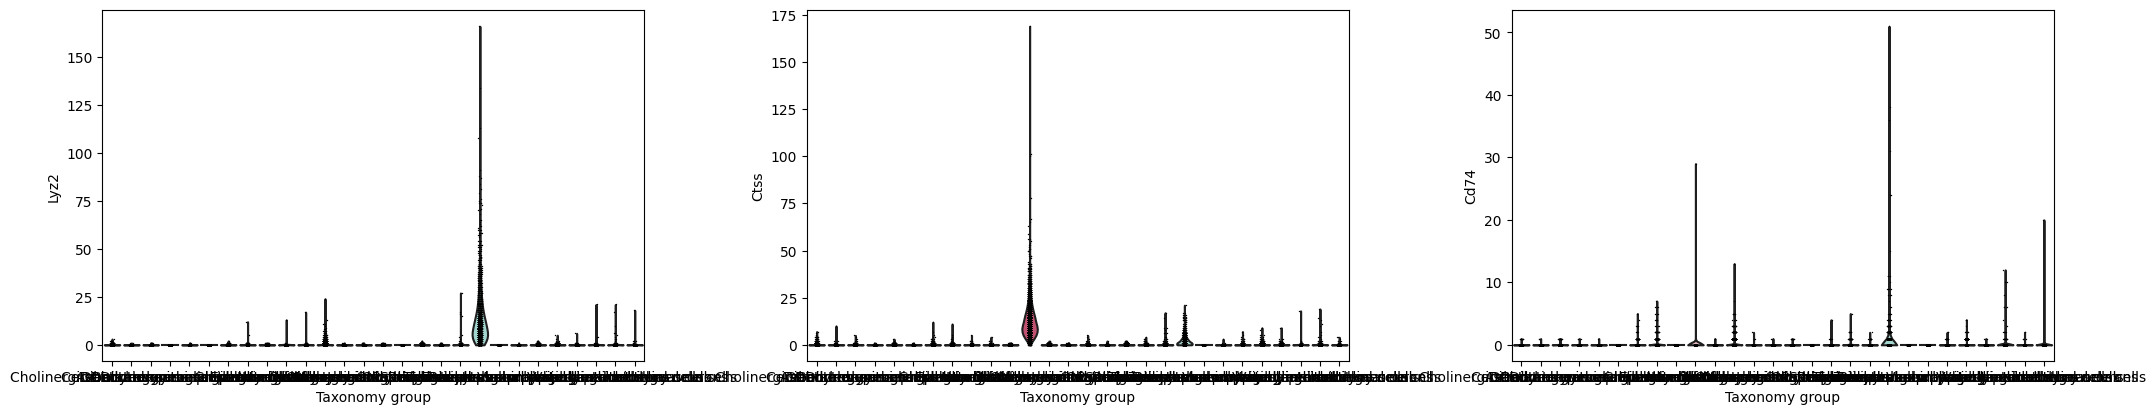

In [36]:
sc.pl.violin(adata_zeisel, ['Lyz2', 'Ctss', 'Cd74'], groupby='Taxonomy_group')

**Conclusion** Peripheral Glia have most overlap with brain pericytes and we keep the ependymal cells as extra category.

In [37]:
adata_zeisel.obs['Taxonomy_group'].cat.categories

Index(['Astrocytes', 'Cerebellum neurons',
       'Cholinergic and monoaminergic neurons', 'Choroid epithelial cells',
       'Dentate gyrus granule neurons', 'Dentate gyrus radial glia-like cells',
       'Di- and mesencephalon excitatory neurons',
       'Di- and mesencephalon inhibitory neurons', 'Ependymal cells',
       'Glutamatergic neuroblasts', 'Hindbrain neurons', 'Microglia',
       'Non-glutamatergic neuroblasts', 'Olfactory ensheathing cells',
       'Olfactory inhibitory neurons', 'Oligodendrocyte precursor cells',
       'Oligodendrocytes', 'Peptidergic neurons', 'Pericytes',
       'Perivascular macrophages', 'Subcommissural organ hypendymal cells',
       'Subventricular zone radial glia-like cells',
       'Telencephalon inhibitory interneurons',
       'Telencephalon projecting excitatory neurons',
       'Telencephalon projecting inhibitory neurons',
       'Vascular and leptomeningeal cells', 'Vascular endothelial cells',
       'Vascular smooth muscle cells'],
   

In [38]:
# # from scib code (not used)
# adata_zeisel.obs['cell_type'] = adata_zeisel.obs['Taxonomy_group'].cat.add_categories(['astrocyte', 
#         'brain pericyte', 'endothelial cell','ependymal cell','neuron',
#        'macrophage', 'microglial cell', 'oligodendrocyte',
#                      'oligodendrocyte precursor cell',
#                          'olfactory ensheathing cell', ])

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Astrocytes','Subventricular zone radial glia-like cells',
#                                      'Dentate gyrus radial glia-like cells'])] =  'astrocyte'
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Ependymal cells', 
#                                       'Subcommissural organ hypendymal cells'])] = 'ependymal cell'
         
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Perivascular macrophages'])] = 'macrophage'
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Microglia'])] = 'microglial cell'
           
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Telencephalon inhibitory interneurons',
#        'Telencephalon projecting excitatory neurons',
#        'Telencephalon projecting inhibitory neurons', 
#                                       'Di- and mesencephalon excitatory neurons',
#        'Di- and mesencephalon inhibitory neurons',
#                                       'Cerebellum neurons',
#        'Cholinergic and monoaminergic neurons',
#                                       'Dentate gyrus granule neurons',
#                                       'Non-glutamatergic neuroblasts',
#                                       'Glutamatergic neuroblasts', 'Hindbrain neurons',
#                                       'Spinal cord excitatory neurons',
#                                       'Olfactory inhibitory neurons',
#                                       'Peptidergic neurons',
#        'Spinal cord inhibitory neurons'])] = 'neuron'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Oligodendrocytes'])] = 'oligodendrocyte'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Oligodendrocyte precursor cells'])] = 'oligodendrocyte precursor cell'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Olfactory ensheathing cells'])] = 'olfactory ensheathing cell'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Pericytes'])] = 'brain pericyte'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Vascular and leptomeningeal cells', 'Vascular endothelial cells',
#        'Vascular smooth muscle cells', 'Choroid epithelial cells'])] = 'endothelial cell'

# adata_zeisel.obs['cell_type'] = adata_zeisel.obs['cell_type'].cat.remove_unused_categories()


In [39]:
# updated own (used)
adata_zeisel.obs['cell_type'] = adata_zeisel.obs['Taxonomy_group'].cat.add_categories(
        ['astrocytes','pericytes', 'Endothelial cells','Ependymal cell','Neurons','Neuroblasts',
        'Microglia/Macrophages', 'Oligos','SMCs', 'OPCs','olfactory ensheathing cells', 'Leptomeningeal cells']) # cannot be same name as "Taxonomy_group"

In [40]:
list(adata_zeisel.obs['Taxonomy_group'].unique())

['Oligodendrocytes',
 'Cholinergic and monoaminergic neurons',
 'Telencephalon projecting excitatory neurons',
 'Telencephalon inhibitory interneurons',
 'Olfactory inhibitory neurons',
 'Peptidergic neurons',
 'Di- and mesencephalon excitatory neurons',
 'Glutamatergic neuroblasts',
 'Hindbrain neurons',
 'Telencephalon projecting inhibitory neurons',
 'Olfactory ensheathing cells',
 'Non-glutamatergic neuroblasts',
 'Dentate gyrus radial glia-like cells',
 'Subventricular zone radial glia-like cells',
 'Oligodendrocyte precursor cells',
 'Ependymal cells',
 'Subcommissural organ hypendymal cells',
 'Dentate gyrus granule neurons',
 'Cerebellum neurons',
 'Di- and mesencephalon inhibitory neurons',
 'Vascular and leptomeningeal cells',
 'Vascular smooth muscle cells',
 'Pericytes',
 'Vascular endothelial cells',
 'Microglia',
 'Perivascular macrophages',
 'Astrocytes',
 'Choroid epithelial cells']

In [41]:
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Astrocytes','Subventricular zone radial glia-like cells',
                                     'Dentate gyrus radial glia-like cells'])] =  'Astrocytes'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Ependymal cells','Subcommissural organ hypendymal cells', 'Choroid epithelial cells'])] = 'Ependymal cells'
         
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Microglia','Perivascular macrophages'])] = 'Microglia/Macrophages'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     [ 'Cholinergic and monoaminergic neurons','Telencephalon projecting excitatory neurons','Telencephalon inhibitory interneurons',
                                      'Olfactory inhibitory neurons','Peptidergic neurons','Di- and mesencephalon excitatory neurons','Hindbrain neurons',
                                      'Telencephalon projecting inhibitory neurons','Dentate gyrus granule neurons','Cerebellum neurons',
                                      'Di- and mesencephalon inhibitory neurons'])] = 'Neurons'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Glutamatergic neuroblasts',
                                      'Non-glutamatergic neuroblasts'])] = 'Neuroblasts'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocytes'])] = 'Oligos'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocyte precursor cells'])] = 'OPCs'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Olfactory ensheathing cells'])] = 'Olfactory ensheathing cells'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Pericytes'])] = 'Pericytes'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular endothelial cells'])] = 'Endothelial cells'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular smooth muscle cells'])] = 'SMCs'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular and leptomeningeal cells'])] = 'Leptomeningeal cells'

adata_zeisel.obs['cell_type'] = adata_zeisel.obs['cell_type'].cat.remove_unused_categories()


In [42]:
adata_zeisel.obs['cell_type'].value_counts()

Neurons                        63512
Oligos                         26243
Astrocytes                     19755
Microglia/Macrophages           6744
Neuroblasts                     5466
Pericytes                       4156
Endothelial cells               2334
Olfactory ensheathing cells     2031
SMCs                            1575
Leptomeningeal cells            1491
Ependymal cells                 1419
OPCs                             733
Name: cell_type, dtype: int64

In [43]:
adata_zeisel.obs['study'] = 'Zeisel'

In [44]:
##Keep tissue, subclass, age and region.
#adata_zeisel.obs['Region']
#adata_zeisel.obs['Age']
#adata_zeisel.obs['Subclass']
#adata_zeisel.obs['Tissue']

In [45]:
del adata_zeisel.obs['AnalysisPool']
del adata_zeisel.obs['AnalysisProject']
del adata_zeisel.obs['Bucket']
del adata_zeisel.obs['CellConc']
del adata_zeisel.obs['Cell_Conc']
del adata_zeisel.obs['ChipID']
del adata_zeisel.obs['Class']
del adata_zeisel.obs['ClassProbability_Astrocyte']
del adata_zeisel.obs['ClassProbability_Astrocyte,Immune']
del adata_zeisel.obs['ClassProbability_Astrocyte,Neurons']
del adata_zeisel.obs['ClassProbability_Astrocyte,Oligos']
del adata_zeisel.obs['ClassProbability_Astrocyte,Vascular']
del adata_zeisel.obs['ClassProbability_Bergmann-glia']
del adata_zeisel.obs['ClassProbability_Blood']
del adata_zeisel.obs['ClassProbability_Blood,Vascular']
del adata_zeisel.obs['ClassProbability_Enteric-glia']
del adata_zeisel.obs['ClassProbability_Enteric-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Ependymal']
del adata_zeisel.obs['ClassProbability_Ex-Neurons']
del adata_zeisel.obs['ClassProbability_Ex-Vascular']
del adata_zeisel.obs['ClassProbability_Immune']
del adata_zeisel.obs['ClassProbability_Immune,Neurons']
del adata_zeisel.obs['ClassProbability_Immune,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons']
del adata_zeisel.obs['ClassProbability_Neurons,Cycling']
del adata_zeisel.obs['ClassProbability_Neurons,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons,Satellite-glia']
del adata_zeisel.obs['ClassProbability_Neurons,Vascular']
del adata_zeisel.obs['ClassProbability_OEC']
del adata_zeisel.obs['ClassProbability_Oligos']
del adata_zeisel.obs['ClassProbability_Oligos,Cycling']
del adata_zeisel.obs['ClassProbability_Oligos,Vascular']
del adata_zeisel.obs['ClassProbability_Satellite-glia']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Schwann']
del adata_zeisel.obs['ClassProbability_Schwann']
del adata_zeisel.obs['ClassProbability_Ttr'] 
del adata_zeisel.obs['ClassProbability_Vascular']
del adata_zeisel.obs['ClusterName']
del adata_zeisel.obs['Clusters']
del adata_zeisel.obs['Comment']
del adata_zeisel.obs['Comments']
del adata_zeisel.obs['DateCaptured']
del adata_zeisel.obs['Date_Captured']
del adata_zeisel.obs['Description']
del adata_zeisel.obs['Developmental_compartment']
del adata_zeisel.obs['DonorID']
del adata_zeisel.obs['Estimated Number of Cells']
del adata_zeisel.obs['Flowcell']
del adata_zeisel.obs['Fraction Reads in Cells']
del adata_zeisel.obs['Label']
del adata_zeisel.obs['LeafOrder']
del adata_zeisel.obs['Location_based_on']
del adata_zeisel.obs['Mean Reads per Cell']
del adata_zeisel.obs['Median Genes per Cell']
del adata_zeisel.obs['Median UMI Counts per Cell']
del adata_zeisel.obs['MitoRiboRatio']
del adata_zeisel.obs['NGI_PlateWell']
del adata_zeisel.obs['Neurotransmitter']
del adata_zeisel.obs['NumPooledAnimals']
del adata_zeisel.obs['Num_Pooled_Animals']
del adata_zeisel.obs['Number of Reads']
del adata_zeisel.obs['OriginalClusters']
del adata_zeisel.obs['Outliers']
del adata_zeisel.obs['PCRCycles']
del adata_zeisel.obs['PCR_Cycles']
del adata_zeisel.obs['PassedQC']
del adata_zeisel.obs['PlugDate']
del adata_zeisel.obs['Plug_Date']
del adata_zeisel.obs['Probable_location']
del adata_zeisel.obs['Project']
del adata_zeisel.obs['Q30 Bases in Barcode']
del adata_zeisel.obs['Q30 Bases in RNA Read']
del adata_zeisel.obs['Q30 Bases in Sample Index']
del adata_zeisel.obs['Q30 Bases in UMI']
del adata_zeisel.obs['Reads Mapped Confidently to Exonic Regions']

In [46]:
del adata_zeisel.obs['Reads Mapped Confidently to Intergenic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Intronic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Transcriptome']
del adata_zeisel.obs['SampleID']
del adata_zeisel.obs['SampleIndex']
del adata_zeisel.obs['SampleOK']
del adata_zeisel.obs['Sample_Index']
del adata_zeisel.obs['SeqComment']
del adata_zeisel.obs['SeqLibDate']
del adata_zeisel.obs['SeqLibOk']
del adata_zeisel.obs['Seq_Comment']
del adata_zeisel.obs['Seq_Lib_Date']
del adata_zeisel.obs['Seq_Lib_Ok']
del adata_zeisel.obs['Sequencing Saturation']
del adata_zeisel.obs['Serial_Number']
del adata_zeisel.obs['Sex']
del adata_zeisel.obs['Species']
del adata_zeisel.obs['Strain']
del adata_zeisel.obs['TargetNumCells']
del adata_zeisel.obs['Target_Num_Cells']
del adata_zeisel.obs['TaxonomyRank1']
del adata_zeisel.obs['TaxonomyRank2']
del adata_zeisel.obs['TaxonomyRank3']
del adata_zeisel.obs['TaxonomyRank4']
del adata_zeisel.obs['TaxonomySymbol']
del adata_zeisel.obs['TimepointPool']
del adata_zeisel.obs['Total Genes Detected']
del adata_zeisel.obs['Transcriptome']
del adata_zeisel.obs['Valid Barcodes']
del adata_zeisel.obs['_KMeans_10']
del adata_zeisel.obs['_LogCV']
del adata_zeisel.obs['_LogMean']
del adata_zeisel.obs['_NGenes']
del adata_zeisel.obs['_PC1']
del adata_zeisel.obs['_PC2']
del adata_zeisel.obs['_Total']
del adata_zeisel.obs['_Valid']
del adata_zeisel.obs['_X']
del adata_zeisel.obs['_Y']
del adata_zeisel.obs['_tSNE1']
del adata_zeisel.obs['_tSNE2']
del adata_zeisel.obs['cDNAConcNanogramPerMicroliter']
del adata_zeisel.obs['cDNALibOk']
del adata_zeisel.obs['cDNA_Lib_Ok']
del adata_zeisel.obs['ngperul_cDNA']

In [47]:
del adata_zeisel.var['Accession']
del adata_zeisel.var['_LogCV']
del adata_zeisel.var['_LogMean']
del adata_zeisel.var['_Selected']
del adata_zeisel.var['_Total']
del adata_zeisel.var['_Valid']

In [48]:
adata = adata_zeisel

In [49]:
adata_zeisel

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study'
    uns: 'Taxonomy_group_colors'

In [50]:
adata_zeisel

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study'
    uns: 'Taxonomy_group_colors'

In [52]:
sc.write(adata=adata_zeisel, filename=main_dir+'/P06_Foxf2_per_celltype/scRNAseq/'+date.today().strftime("%Y%m%d")+'_Zeisel2018.h5ad')

---

## Load previous work

In [15]:
# load final file
adata=sc.read_h5ad(main_dir+'/P06_Foxf2_per_celltype/scRNAseq/20231109_zeisel_normalised_logarithmised_annotated.h5ad')
#adata.uns['log1p']['base'] = None

In [16]:
adata

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'cell_type_colors', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

# QC

Not required because already annotated

normalizing counts per cell
    finished (0:00:00)


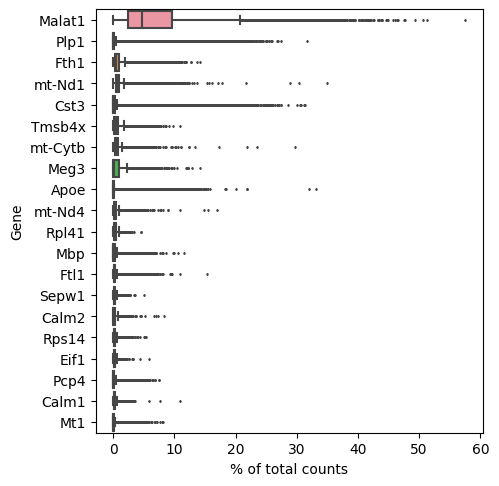

In [53]:
# genes with highest fraction of counts per cell
sc.pl.highest_expr_genes(adata, n_top=20, )

# Normalisation, logarithmization

In [54]:
adata.layers

Layers with keys: 

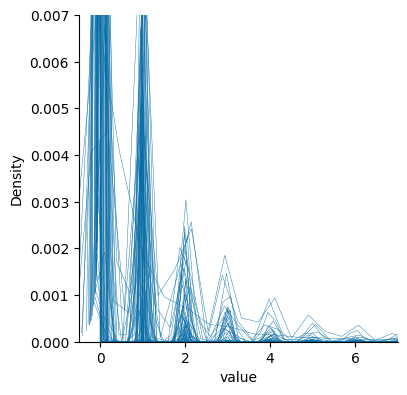

In [55]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_19812/1570369789.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


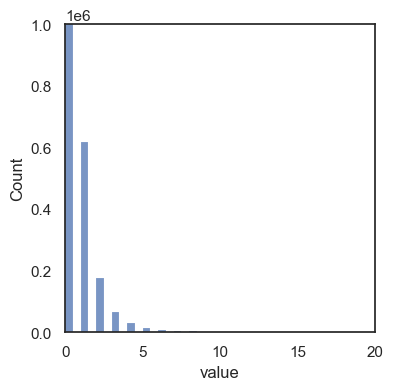

In [56]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e6));

In [57]:
adata.layers["counts"] = adata.X.copy() # save unnormalized raw RNA counts - retrieve via adata.X = adata.layers["counts"]

In [58]:
sc.pp.normalize_total(adata, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


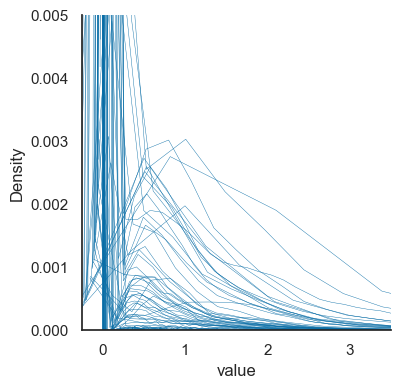

In [59]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3)
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_19812/1099010557.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


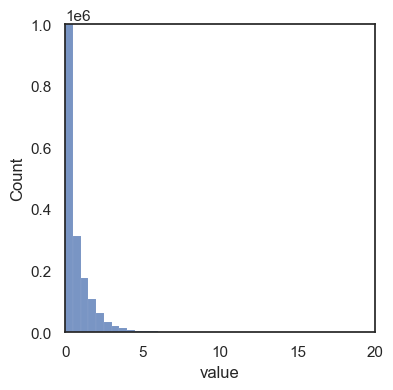

In [60]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e6));

In [61]:
sc.pp.log1p(adata) # X = log(X + 1)

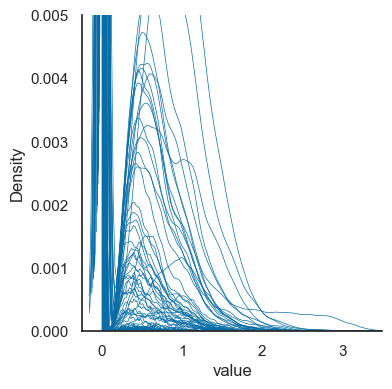

In [62]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_19812/4197083167.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


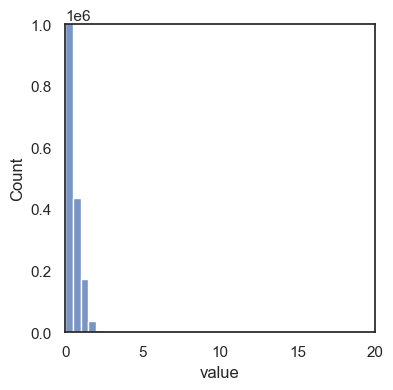

In [63]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 20),ylim=(0,1e6));

In [64]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


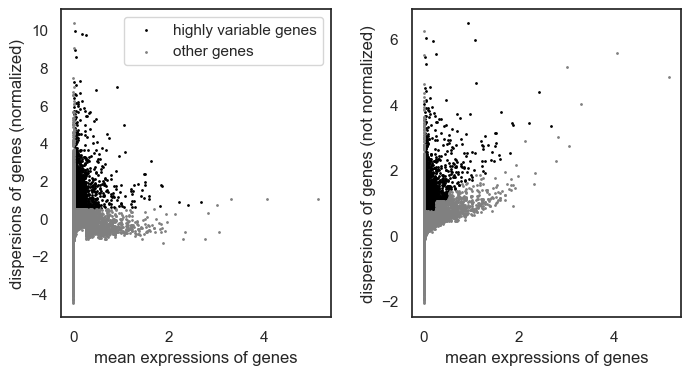

In [65]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [66]:
adata

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [67]:
adata.layers

Layers with keys: counts, normalized

# Dim Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


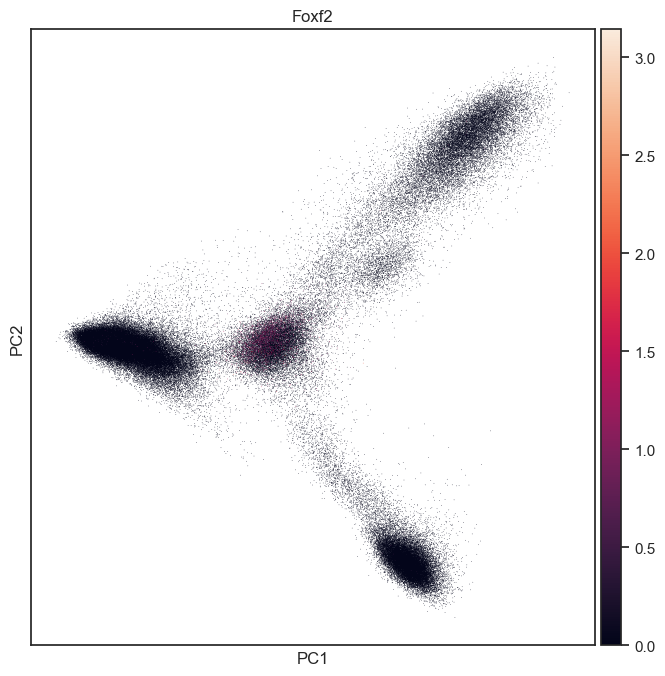

In [68]:
# Run PCA
with rc_context({'figure.figsize': (8, 8)}):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color='Foxf2')

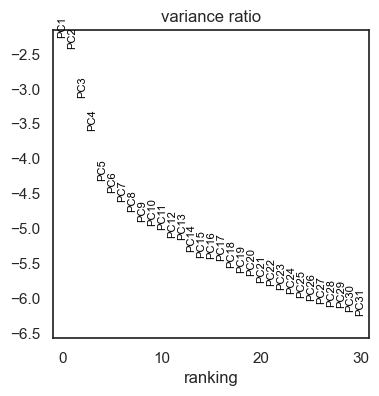

In [69]:
sc.pl.pca_variance_ratio(adata, log=True)

In [70]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


In [71]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:02)


In [72]:
list(adata.obs.columns)

['Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study']

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


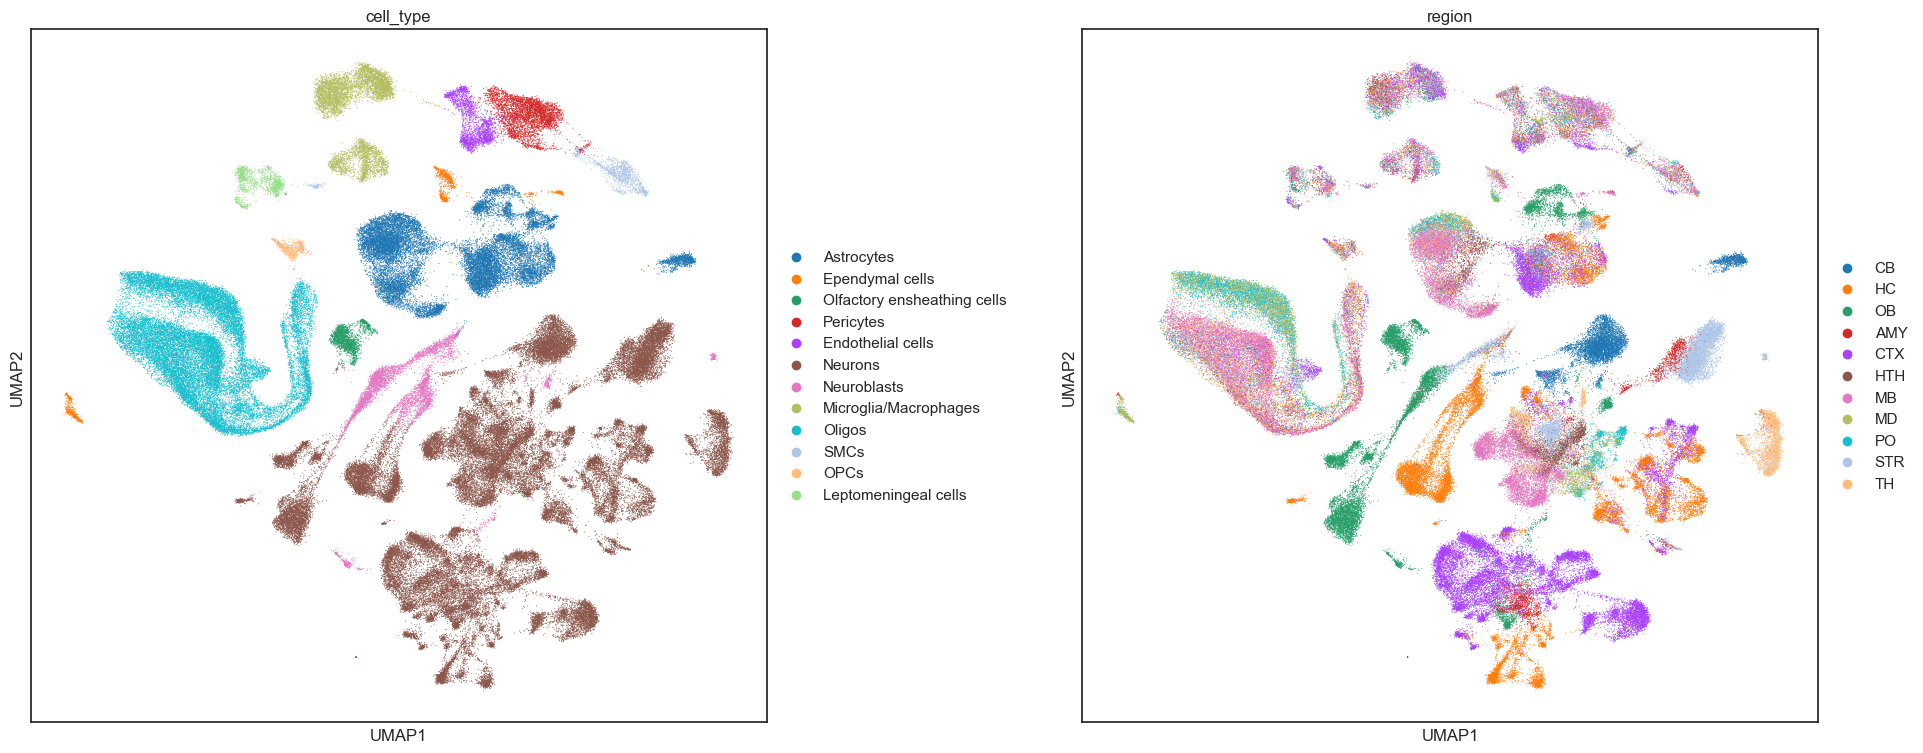

In [73]:
with rc_context({'figure.figsize': (9, 9)}):
    sc.pl.umap(adata, color=['cell_type', 'region'], wspace=0.3, size=2)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


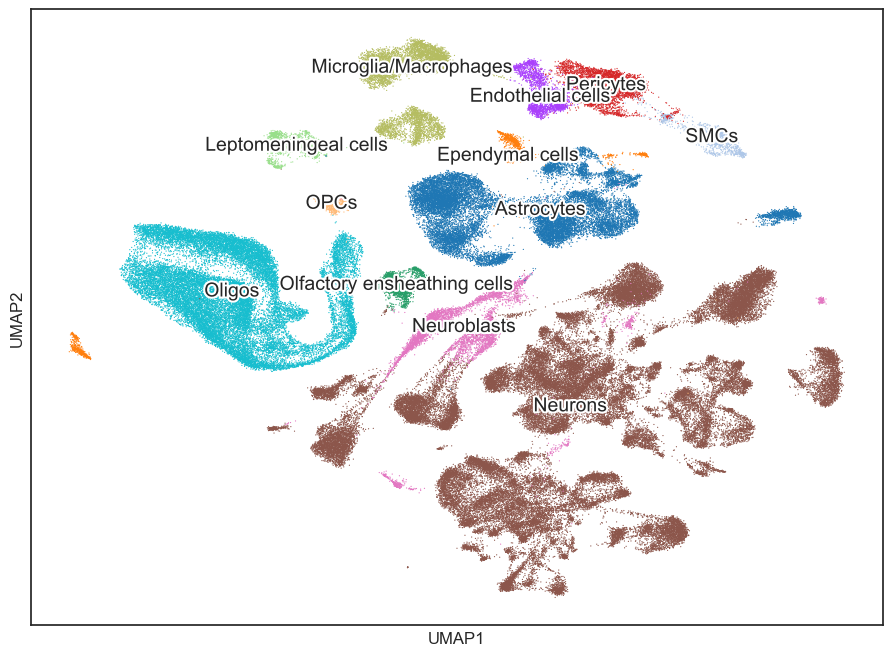

In [74]:
plt.rcParams['figure.figsize'] = [11, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=3, legend_fontsize=14, size=3)

Note: UMAP does not separate cell types very well, nonetheless stick to pre-annotated cell types

# Cell annotation

Verify annotation from authors

Manual marker gene selection

|Vascular     |EC         |Pericytes|SMCs   |Fibroblasts|Oligos|OPCs         |Ependymal|Neurons    |immature/migrating Neurons|Astrocytes|Microglia|Immune (broad/hematopoetic)|Macrophages     |Macrophages/Microglia|Monocytes|Mononcytes/B-cells|Granulocytes|B-cells|T/NK cells|
|---          |---        |---      |---    |---        |---   |---          |---      |---        |---   |---       |---      |---                        |---             |---|---|---|---|---|---|
|PDGFRA =CD140A|CLDN5      |VTN      |ACTA2  |DCN        |MBP   |CSPG4 =NG2    |PIFO     |RBFOX3 =NEUN|DCX   |AQP4      |AIF1     |PTPRC =CD45                 |CD14            |TREM2|CCR2|CD74|CD16/32|CD19|CD4|
|MCAM =CD146   |PECAM1 =CD31|PDGFRB   |MYOCD  |COL6A1     |ENPP2 |PDGFRA =CD140A|FOXJ1    |TUBB3      ||          |         |                           |ITGB2 =CD18 =CD11B||||ITGB2 =CD18 =CD11B||CD8A|
|FOXF2        |           |         |       |COL3A1     |      |             |DYNLRB2  |           ||          |         |                           |CD86            ||||CD15||CD8B|
|             |           |         |       |           |      |             |MEIG1    |           ||          |         |                           |ADGRE1 =F4/80    ||||||IL2RB|
||||||||||||||||||||IFNG|

In [ ]:
# plot marker genes
plt.rcParams['figure.figsize'] = [8, 6] # set plot sizes
marker_genes = ["Pdgfra", "Mcam","Foxf2", "Pecam1", "Cldn5","Vtn", "Pdgfrb","Acta2", "Myocd","Dcn", "Col6a1", "Mbp","Enpp2","Cspg4","Pifo","Foxj1","Dynlrb2","Meig1","Rbfox3","Tubb3","Dcx","Aqp4", "Aif1", "Ptprc", "Ccr2","Adgre1","Itgb2","Cd14","Cd86","Trem2","Vcan","Cd4","Cd19", "Cd8a","Il2rb","Cd244", "Cd74","Cd68","Ifng","Ptgdr2","Ccr3"]
marker_genes=[x for x in marker_genes if x in list(adata.var_names)] # remove those not in adata.var_names
sc.pl.umap(adata, ncols=3, color=marker_genes, size=3)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:08)


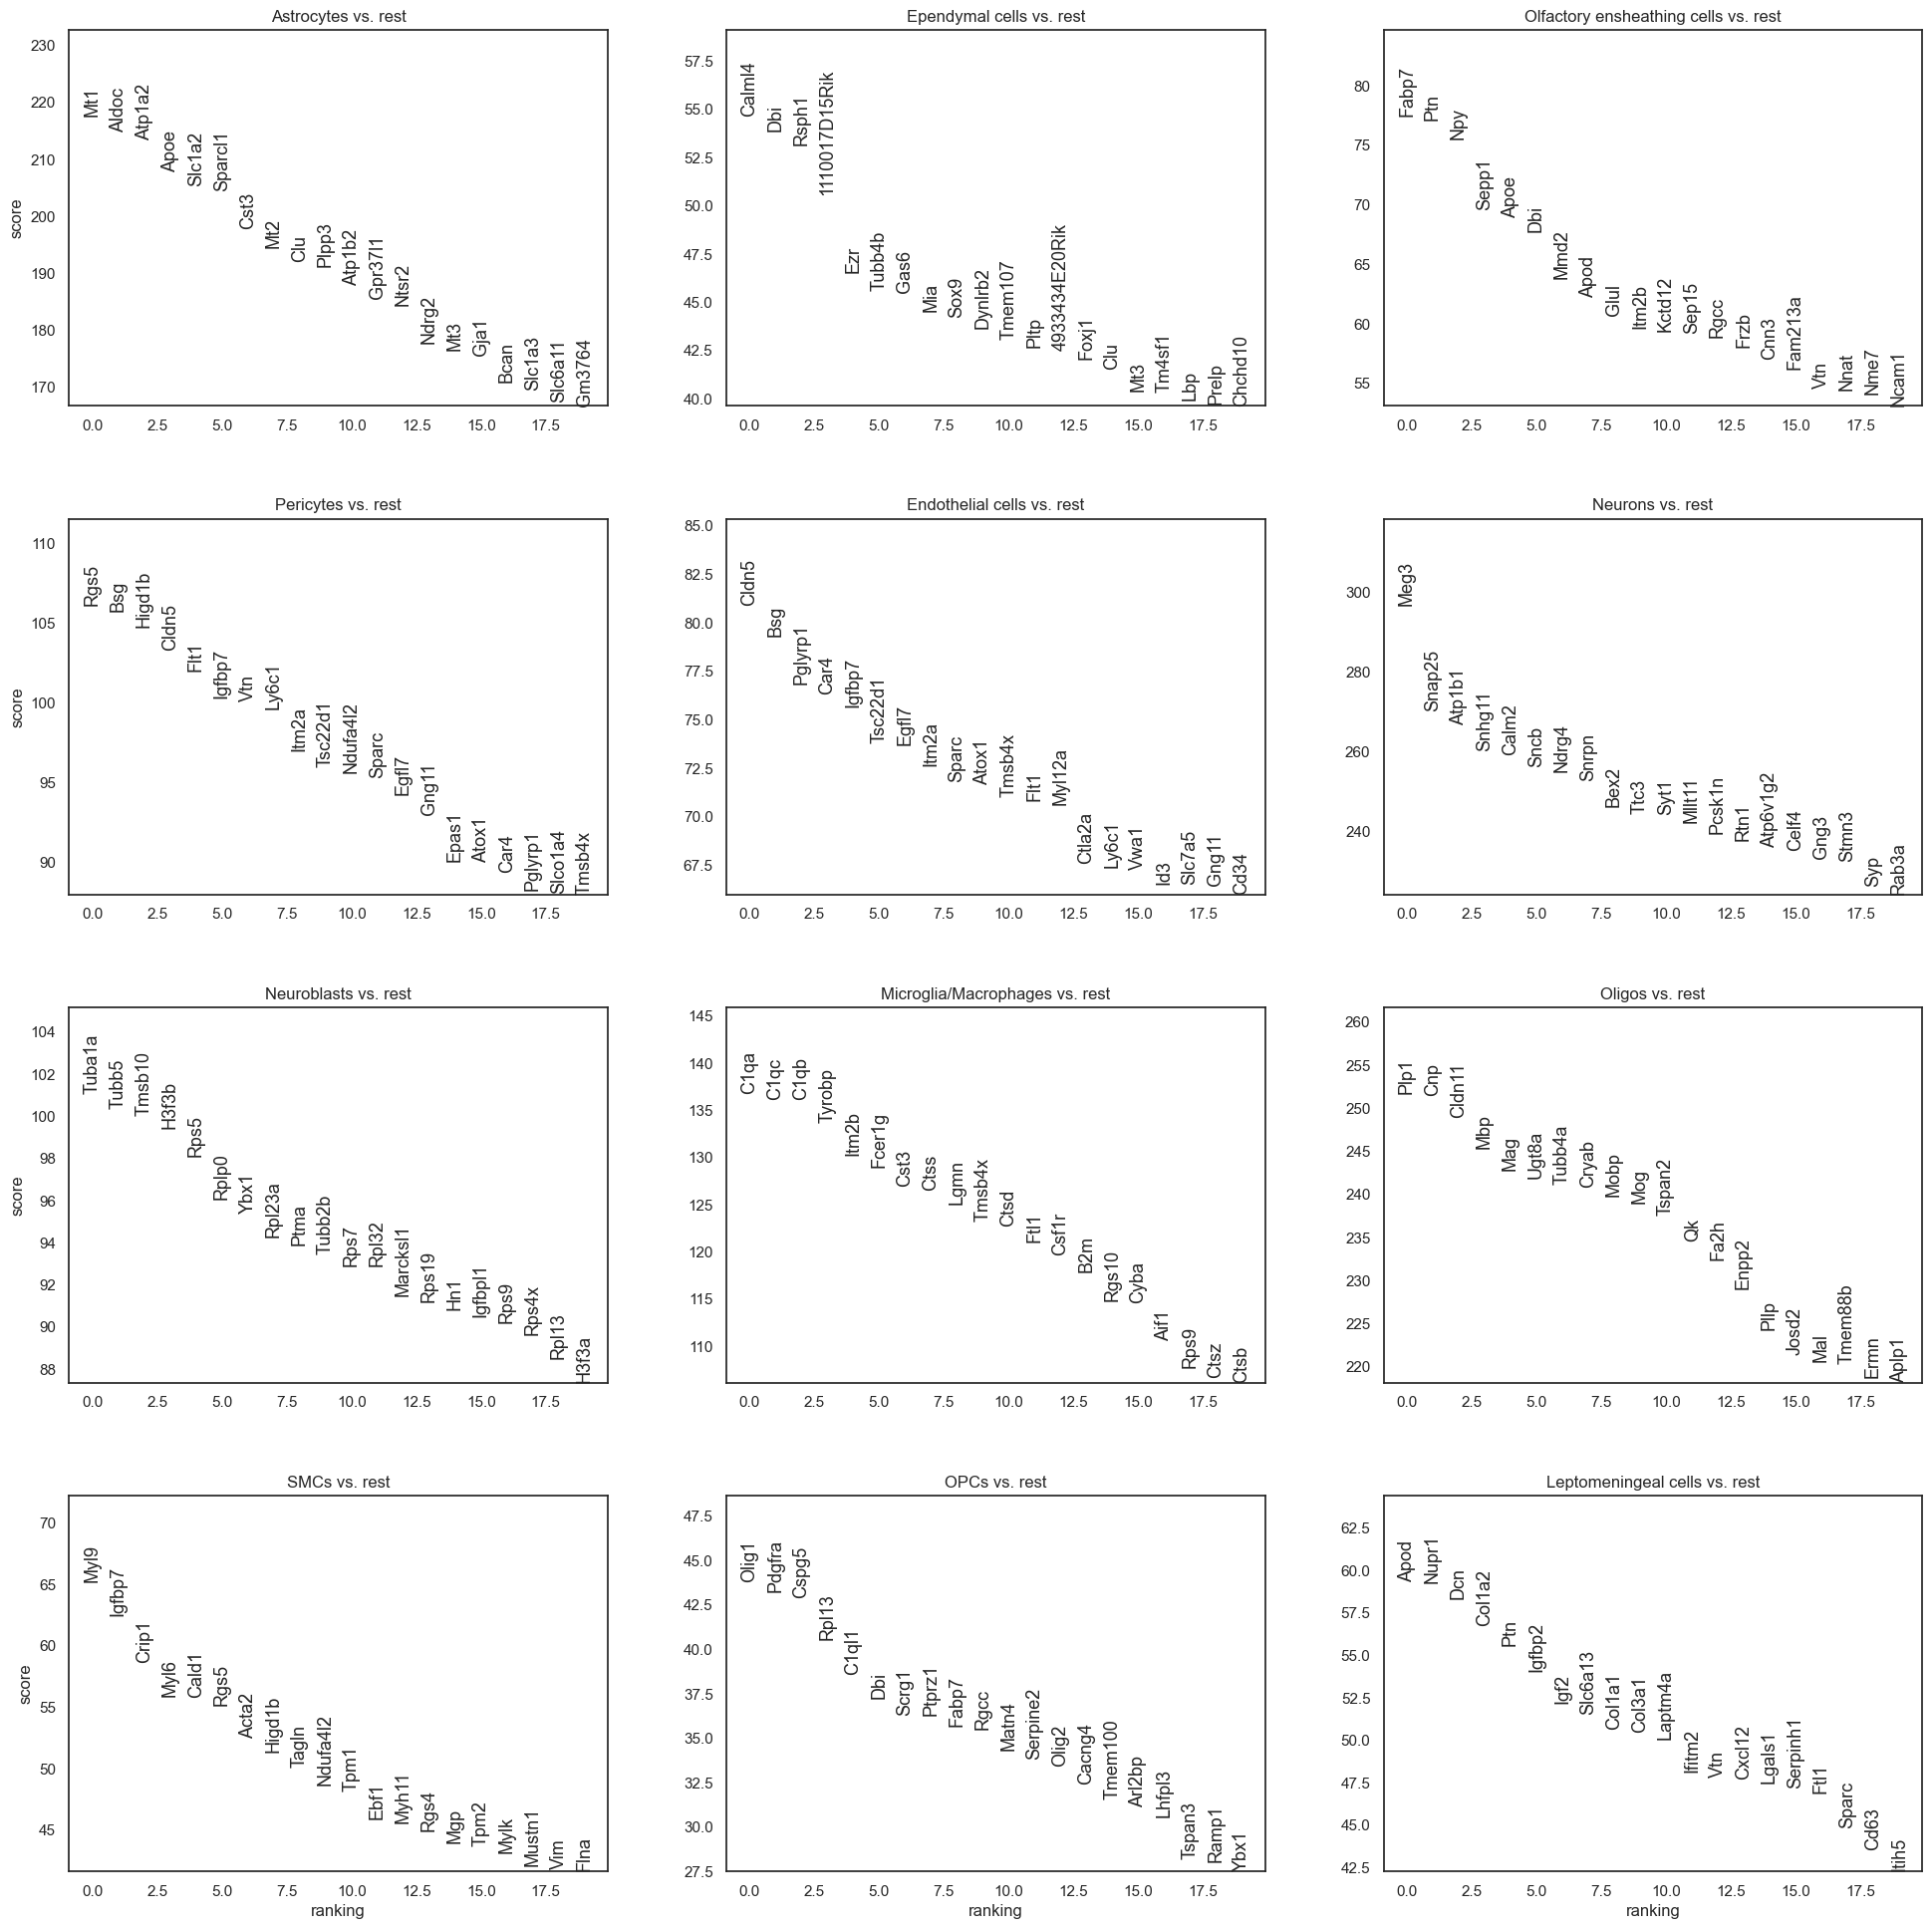

In [76]:
# Run DE test for annotation (Wilcoxon)
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=3, fontsize=13, key='wilcoxon')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


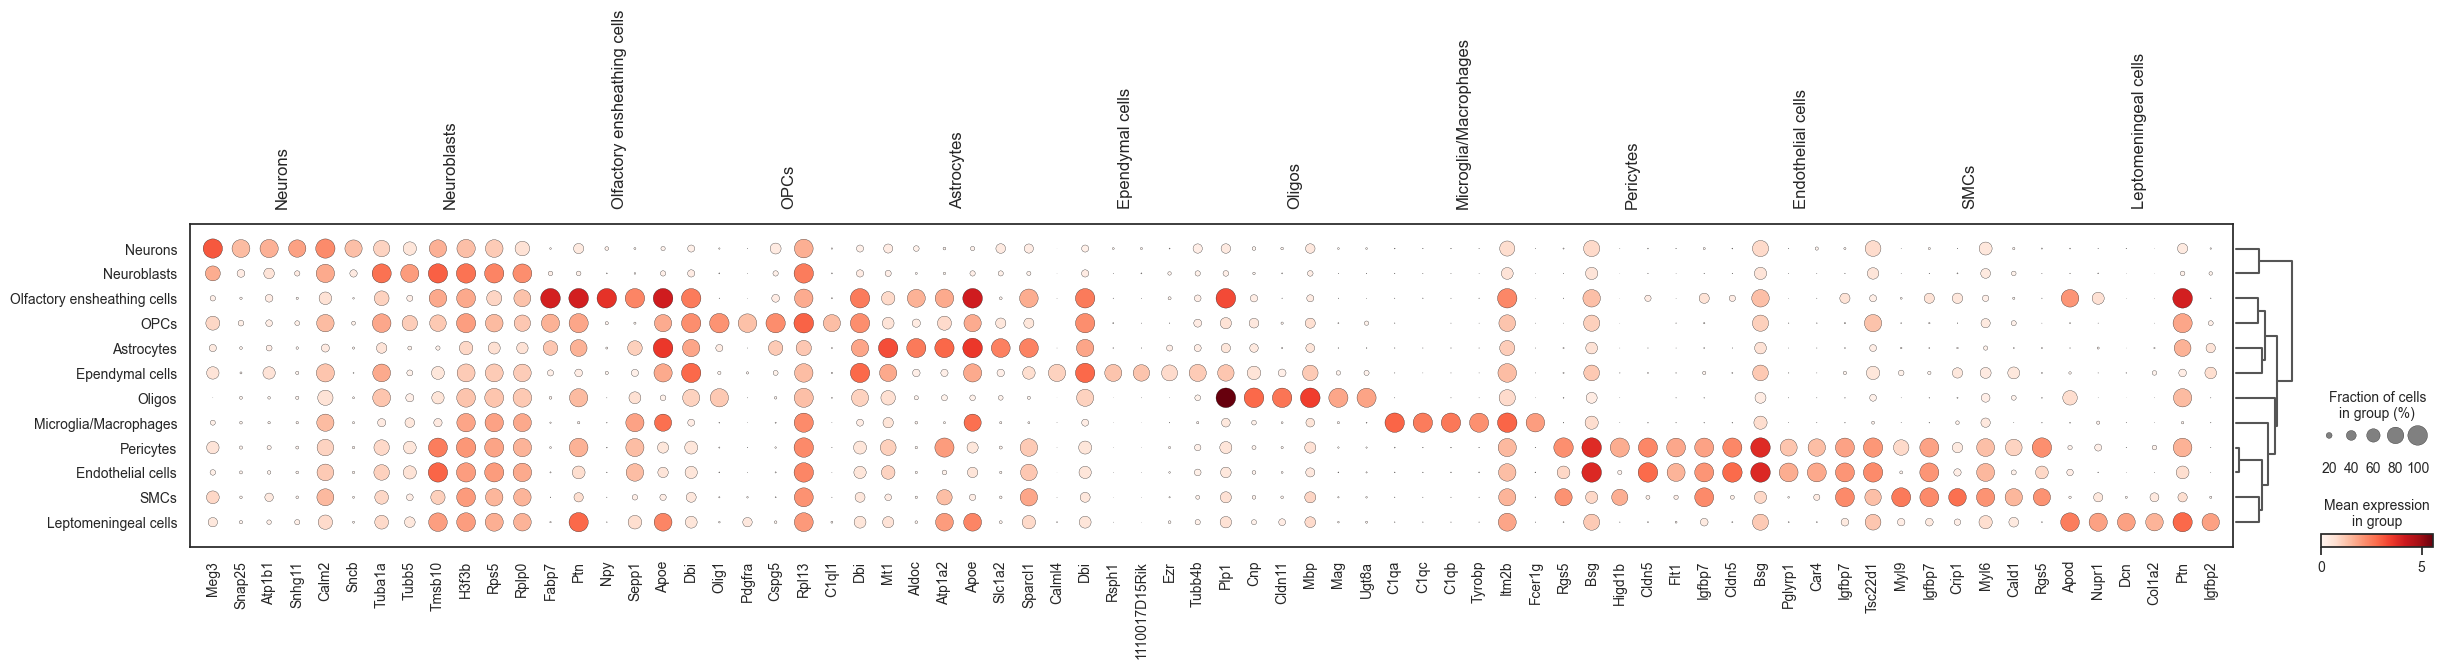

In [77]:
# Dotplot
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, key="wilcoxon", groupby="cell_type");

Note: No re-annotation required

# DE analysis

In [78]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added = "dea")

ranking genes
    finished: added to `.uns['dea']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:13)


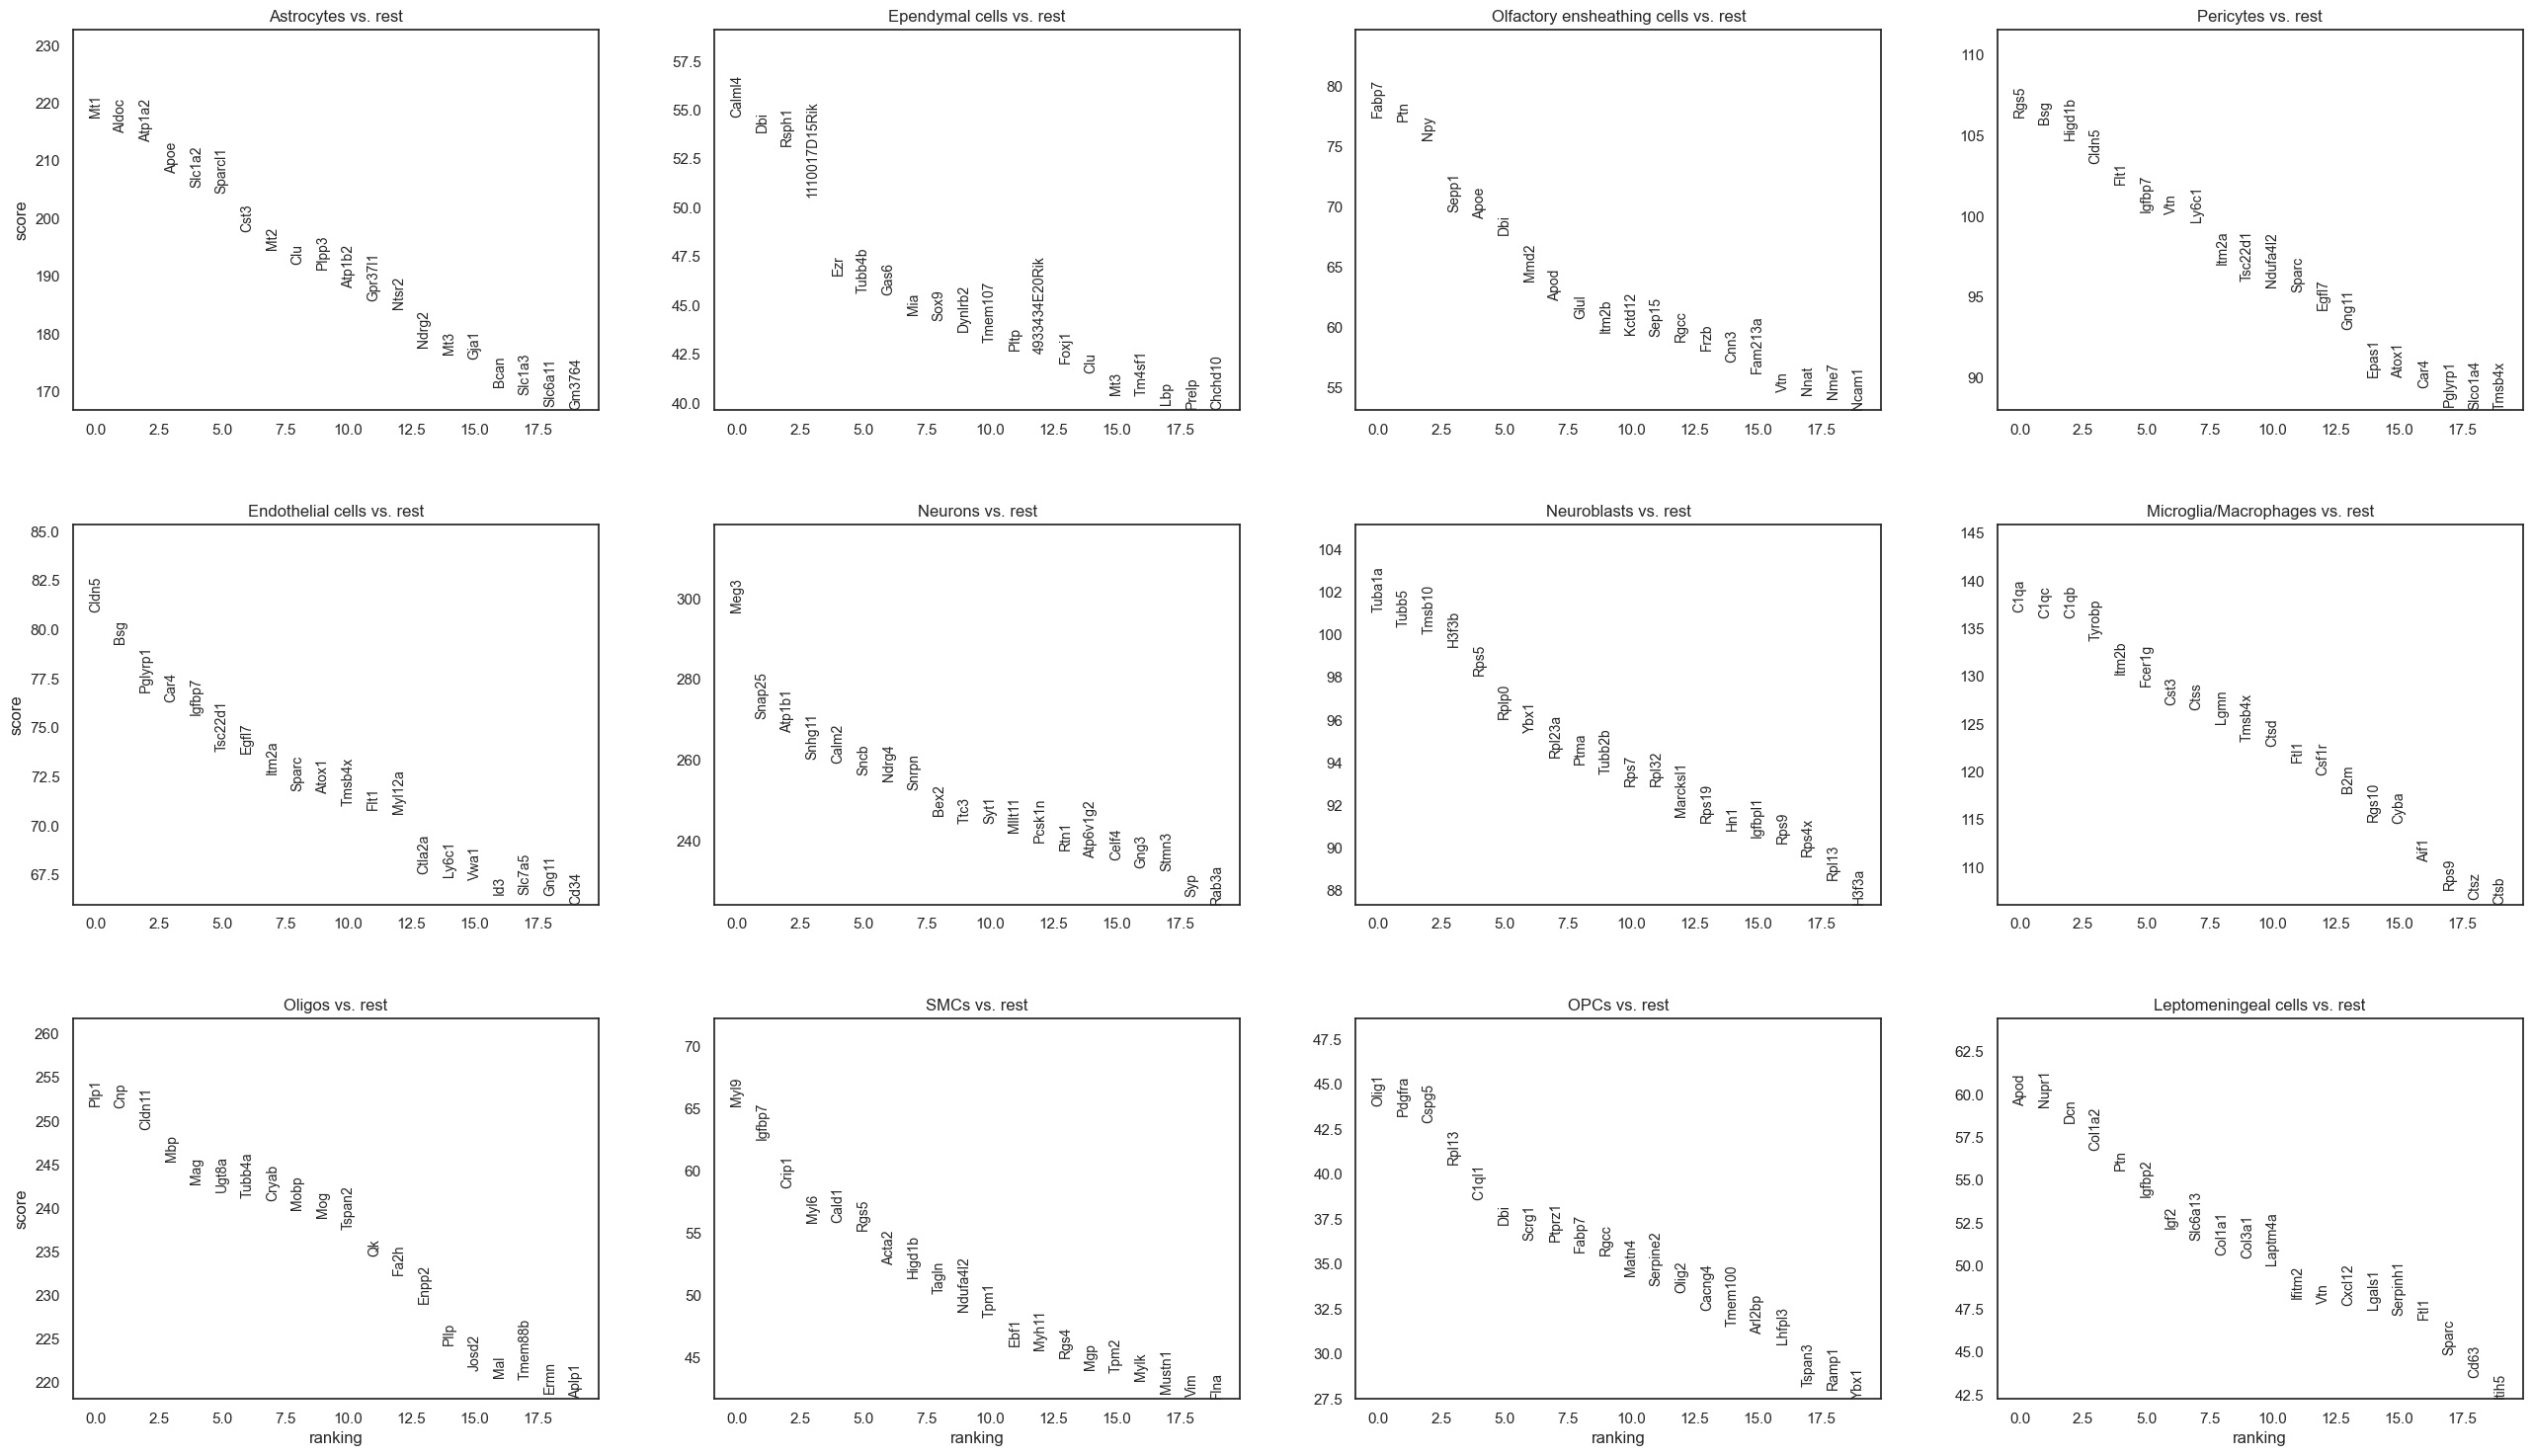

In [79]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key = "dea", fontsize = 10)

In [80]:
sc.get.rank_genes_groups_df(adata, key = "dea", group = "Oligos")[0:15]

names      scores  logfoldchanges  pvals  pvals_adj
0     Plp1  251.670990        8.782572    0.0        0.0
1      Cnp  251.485458        6.585013    0.0        0.0
2   Cldn11  248.926193        8.112093    0.0        0.0
3      Mbp  245.325333        5.682766    0.0        0.0
4      Mag  242.758575        7.805329    0.0        0.0
5    Ugt8a  241.834869        7.929506    0.0        0.0
6   Tubb4a  241.198624        4.086465    0.0        0.0
7    Cryab  240.779724        5.033710    0.0        0.0
8     Mobp  239.794540        6.509305    0.0        0.0
9      Mog  238.919693        8.031951    0.0        0.0
10  Tspan2  237.541901        6.736257    0.0        0.0
11      Qk  234.527786        3.991465    0.0        0.0
12    Fa2h  232.368866        7.849696    0.0        0.0
13   Enpp2  229.025299        4.967966    0.0        0.0
14    Pllp  224.285248        5.745308    0.0        0.0

In [81]:
sc.get.rank_genes_groups_df(adata, key = "dea", group = "Neurons")[0:15]["names"]

0         Meg3
1       Snap25
2       Atp1b1
3       Snhg11
4        Calm2
5         Sncb
6        Ndrg4
7        Snrpn
8         Bex2
9         Ttc3
10        Syt1
11      Mllt11
12      Pcsk1n
13        Rtn1
14    Atp6v1g2
Name: names, dtype: object

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


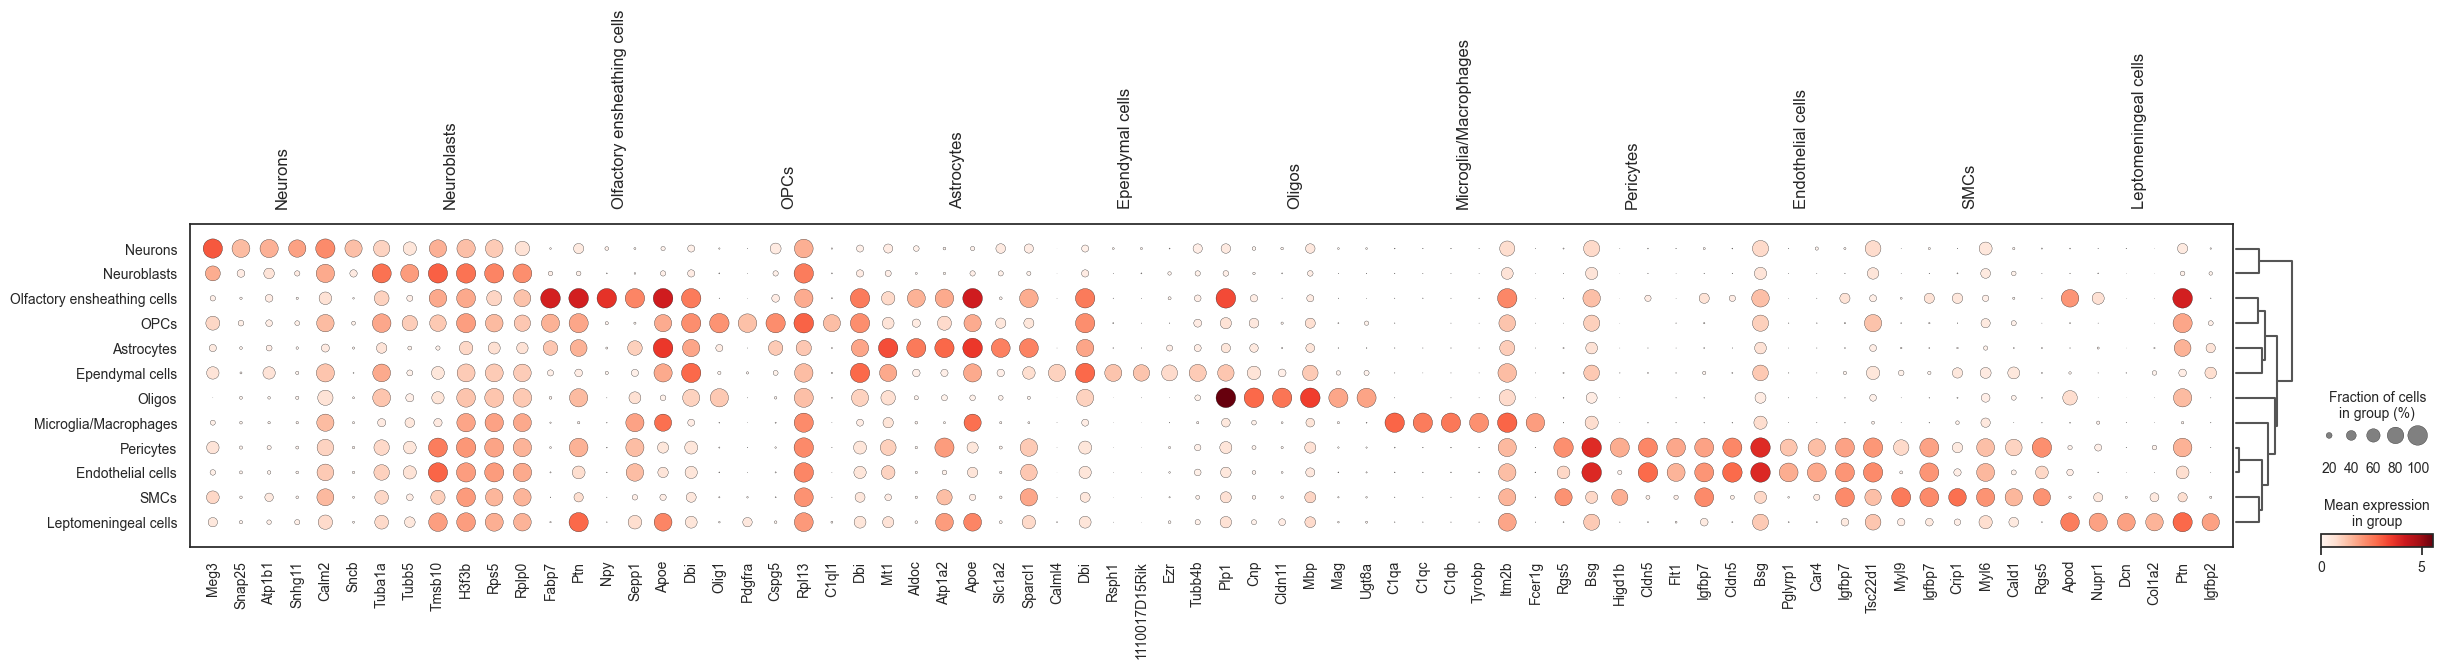

In [82]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, key="dea", groupby="cell_type")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


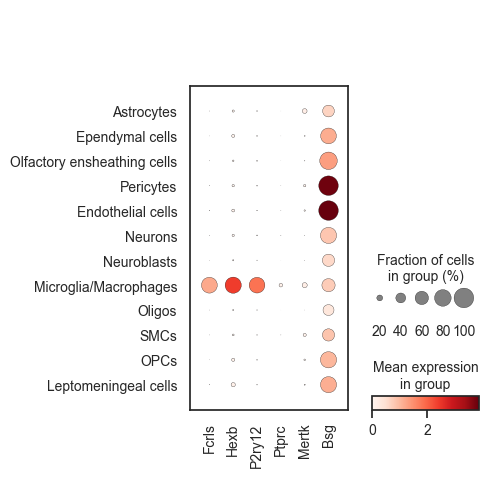

In [83]:
sc.pl.dotplot(adata, var_names=["Fcrls","Hexb","P2ry12","Ptprc","Mertk","Bsg"], groupby="cell_type")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


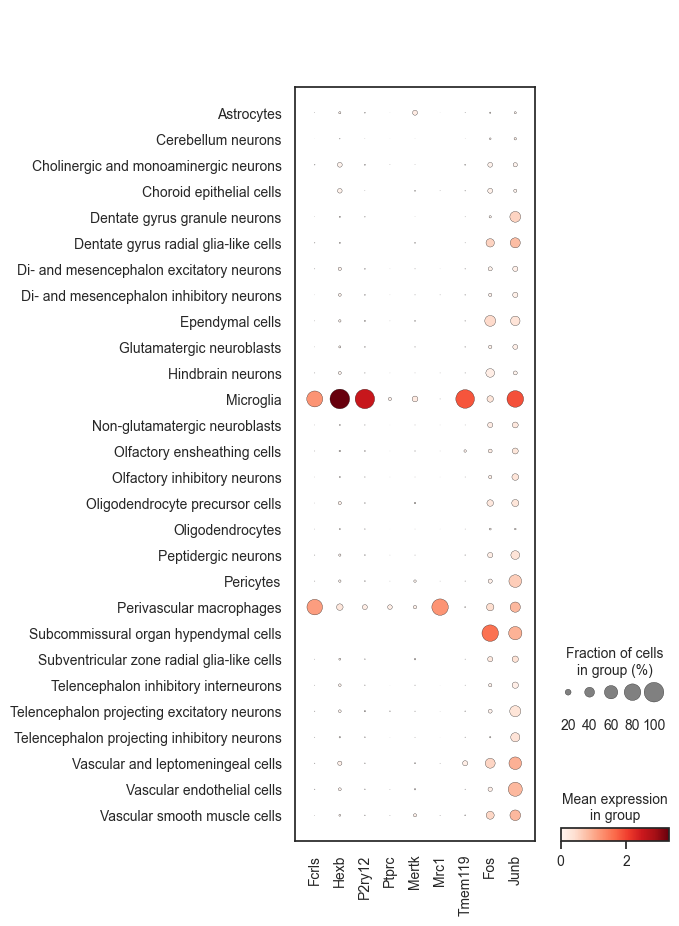

In [84]:
sc.pl.dotplot(adata, var_names=["Fcrls","Hexb","P2ry12","Ptprc","Mertk","Mrc1","Tmem119","Fos","Junb"], groupby="Taxonomy_group")

# Focus on: Foxf2

In [17]:
adata.obs["clusters"] = adata.obs['cell_type']

In [18]:
gene="Foxf2"

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


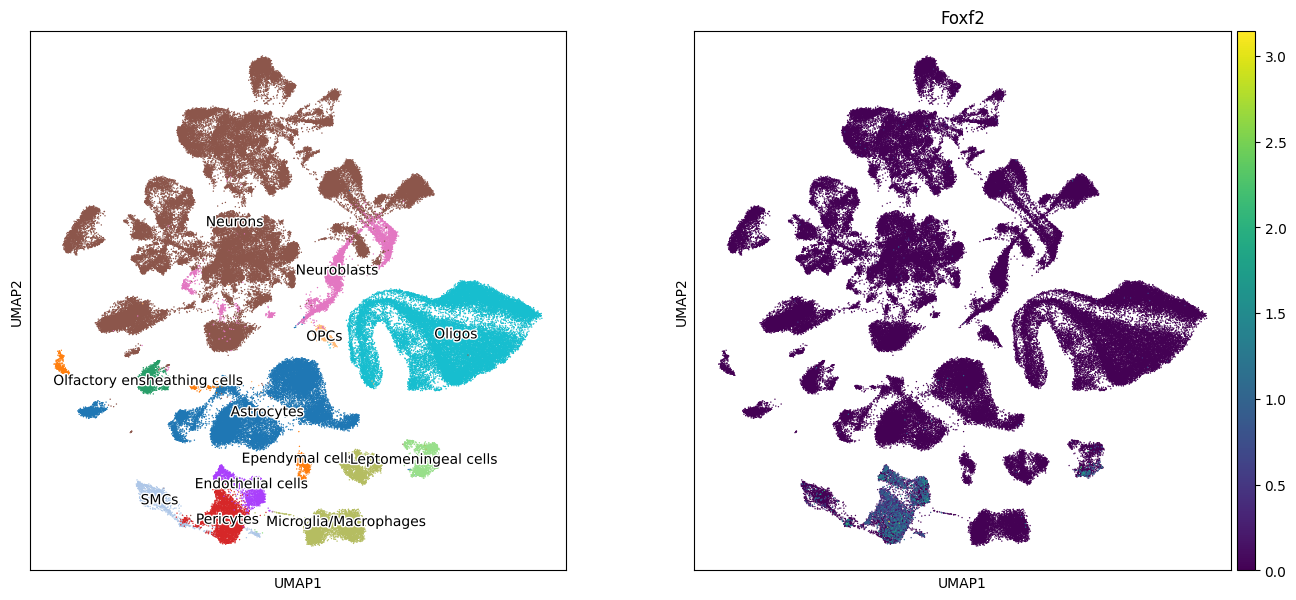

In [19]:
with rc_context({'figure.figsize': (7,7)}):
    sc.pl.umap(adata, color=['clusters',gene], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=10, size=4)

## Plot

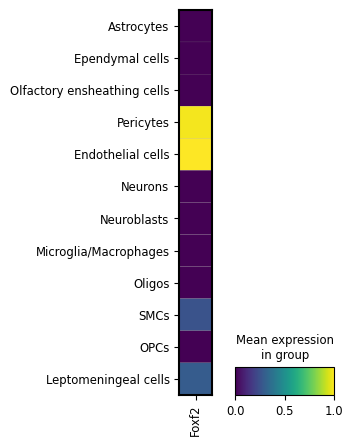

In [20]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


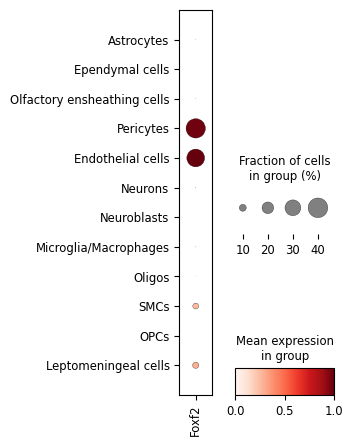

In [21]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [22]:
utils.summarize_gene_expression(adata = adata, gene = gene, groupby = "clusters", 
                          study_name = dataset_name, organism = organism,
                          export = True, output_dir = os.path.join(main_dir, "P06_Foxf2_per_celltype", "Foxf2_summarized")
                         )

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Foxf2_summarized/20250306_Foxf2_Zeisel2018_layernormalized.csv


mean_expression  fraction_of_cells   gene  \
clusters                                                                 
Astrocytes                          0.002439           0.000759  Foxf2   
Ependymal cells                     0.000000           0.000000  Foxf2   
Olfactory ensheathing cells         0.002686           0.000985  Foxf2   
Pericytes                           0.983418           0.392685  Foxf2   
Endothelial cells                   1.000000           0.350471  Foxf2   
Neurons                             0.001980           0.001275  Foxf2   
Neuroblasts                         0.000000           0.000000  Foxf2   
Microglia/Macrophages               0.003101           0.001038  Foxf2   
Oligos                              0.000786           0.000457  Foxf2   
SMCs                                0.257117           0.080000  Foxf2   
OPCs                                0.000000           0.000000  Foxf2   
Leptomeningeal cells                0.288114           0.086519  Foxf2   

                                 source organism  cell_number  
clusters                                                       
Astrocytes                   Zeisel2018    Mouse        19755  
Ependymal cells              Zeisel2018    Mouse         1419  
Olfactory ensheathing cells  Zeisel2018    Mouse         2031  
Pericytes                    Zeisel2018    Mouse         4156  
Endothelial cells            Zeisel2018    Mouse         2334  
Neurons                      Zeisel2018    Mouse        63512  
Neuroblasts                  Zeisel2018    Mouse         5466  
Microglia/Macrophages        Zeisel2018    Mouse         6744  
Oligos                       Zeisel2018    Mouse        26243  
SMCs                         Zeisel2018    Mouse         1575  
OPCs                         Zeisel2018    Mouse          733  
Leptomeningeal cells         Zeisel2018    Mouse         1491

# Focus on: Other genes

In [23]:
target_genes = ["Foxo1", "Tek", "Nos3", "Htra1", "Egfl8", "Flt1", "Kdr", "Ptprb", "Nrp1", "Nrp2", "Efnb2", "Itgb1", "Itga6", "Angpt2", "Cdh5", "Cldn5", "Ocln", "Ctnnb1"]

In [24]:
other_genes_results = {
    gene: utils.summarize_gene_expression(adata, gene, study_name = dataset_name, organism = organism, groupby = "clusters",
                                    output_dir=os.path.join(main_dir, "P06_Foxf2_per_celltype", "Other_genes_summarized"), export=True
                                   ) for gene in target_genes
}

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Foxo1_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Tek_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Nos3_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Htra1_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Egfl8_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Flt1_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Kdr_Zeisel2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Ptprb_Zeisel2018_la

In [25]:
# some plots

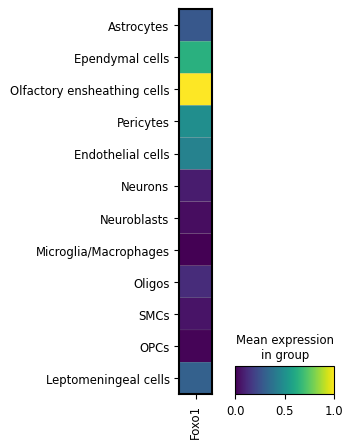

In [26]:
sc.pl.matrixplot(adata, [target_genes[0]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


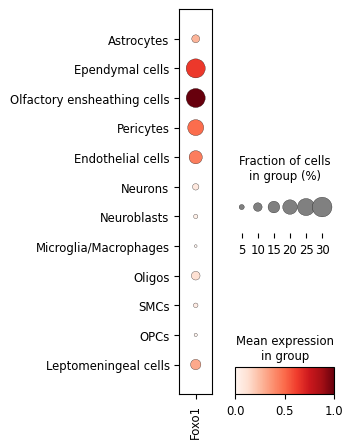

In [27]:
sc.pl.dotplot(adata, [target_genes[0]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

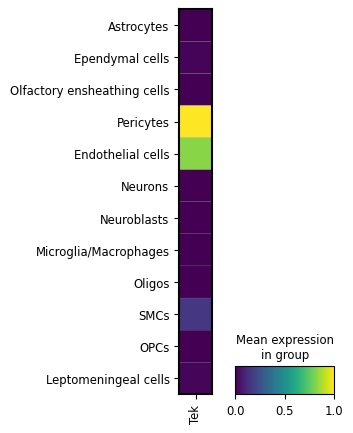

In [28]:
sc.pl.matrixplot(adata, [target_genes[1]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


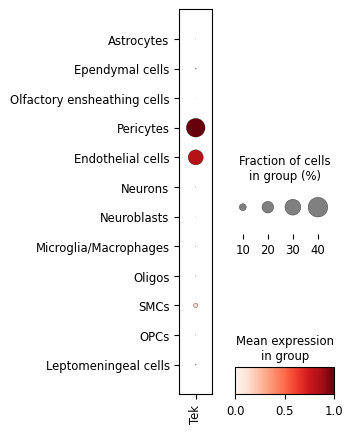

In [29]:
sc.pl.dotplot(adata, [target_genes[1]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

# Correlate gene expression (Foxf2 and Foxo1)

Using MAGIC denoising

In [16]:
import magic
import scprep

In [17]:
#sc.pp.scale(ad_merged)

## ECs

In [65]:
gg = ["Foxf2","Foxo1","Nos3"]

In [66]:
adata_EC = adata[adata.obs.clusters == "Endothelial cells"]

In [67]:
adata_EC

View of AnnData object with n_obs × n_vars = 2334 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'cell_type_colors', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [68]:
adata_EC.layers

LayersView with keys: counts, normalized

In [69]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [70]:
cutoff_var = None

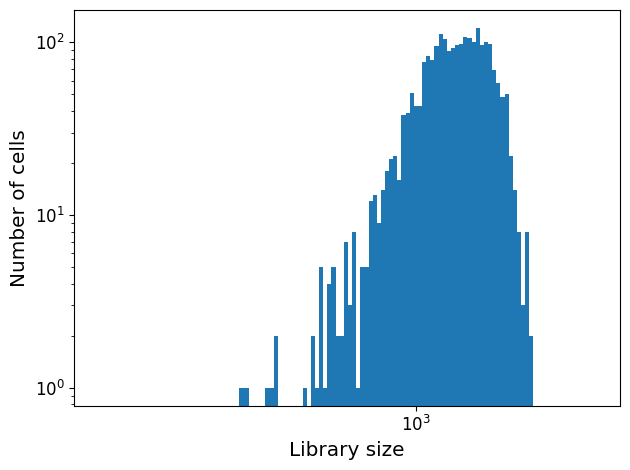

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [71]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [72]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [73]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [74]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [75]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 2334 cells and 27998 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 2.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.64 seconds.
    Calculating affinities...
    Calculated affinities in 0.61 seconds.
  Calculated graph and diffusion operator in 3.45 seconds.
  Calculating imputation...
Calculated MAGIC in 3.55 seconds.
CPU times: total: 5.38 s
Wall time: 3.55 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [76]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

-0.45849830206753883

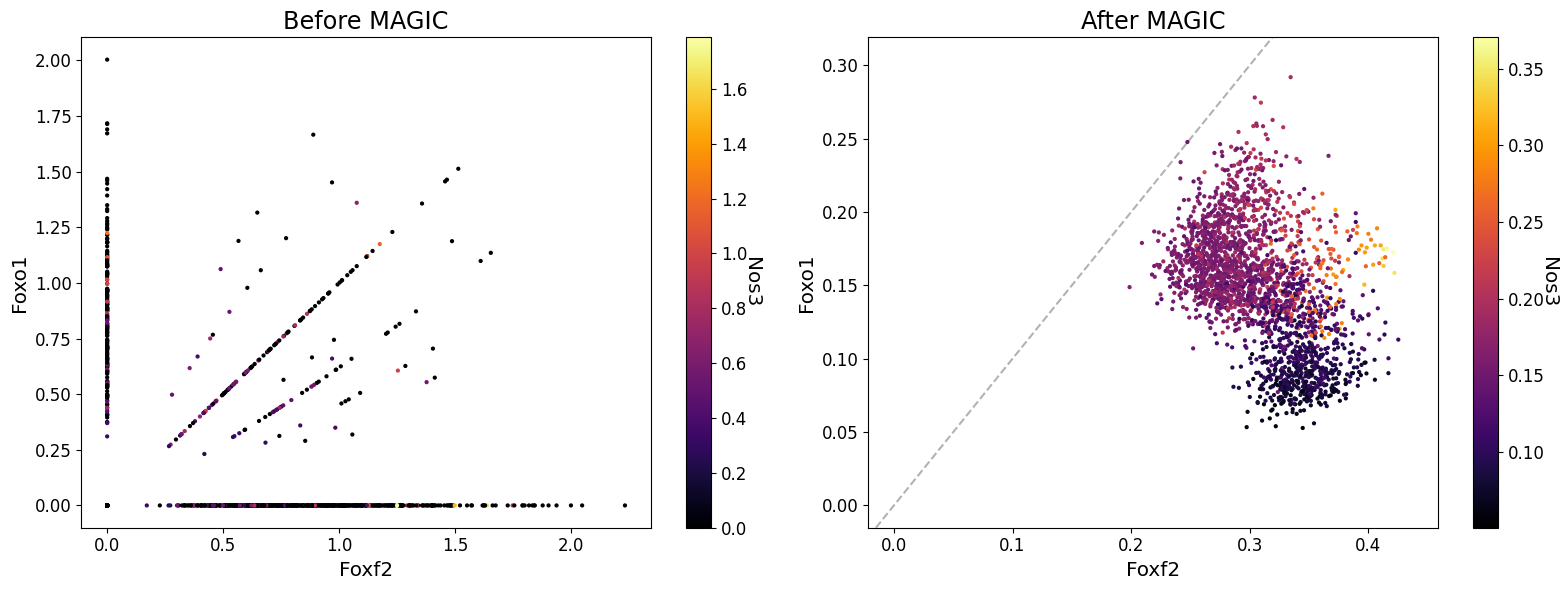

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## PCs

In [78]:
gg = ["Foxf2","Foxo1","Nos3"]

In [79]:
adata_EC = adata[adata.obs.clusters == "Pericytes"]

In [80]:
adata_EC

View of AnnData object with n_obs × n_vars = 4156 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'cell_type_colors', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [81]:
adata_EC.layers

LayersView with keys: counts, normalized

In [82]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [83]:
cutoff_var = None

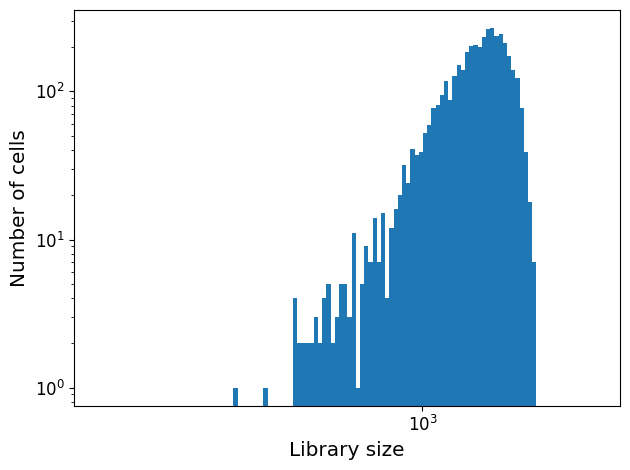

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [84]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [85]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [86]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [87]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [88]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 4156 cells and 27998 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 4.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.16 seconds.
    Calculating affinities...
    Calculated affinities in 2.26 seconds.
  Calculated graph and diffusion operator in 8.44 seconds.
  Calculating imputation...
Calculated MAGIC in 8.57 seconds.
CPU times: total: 10.8 s
Wall time: 8.58 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [89]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.2544032001775421

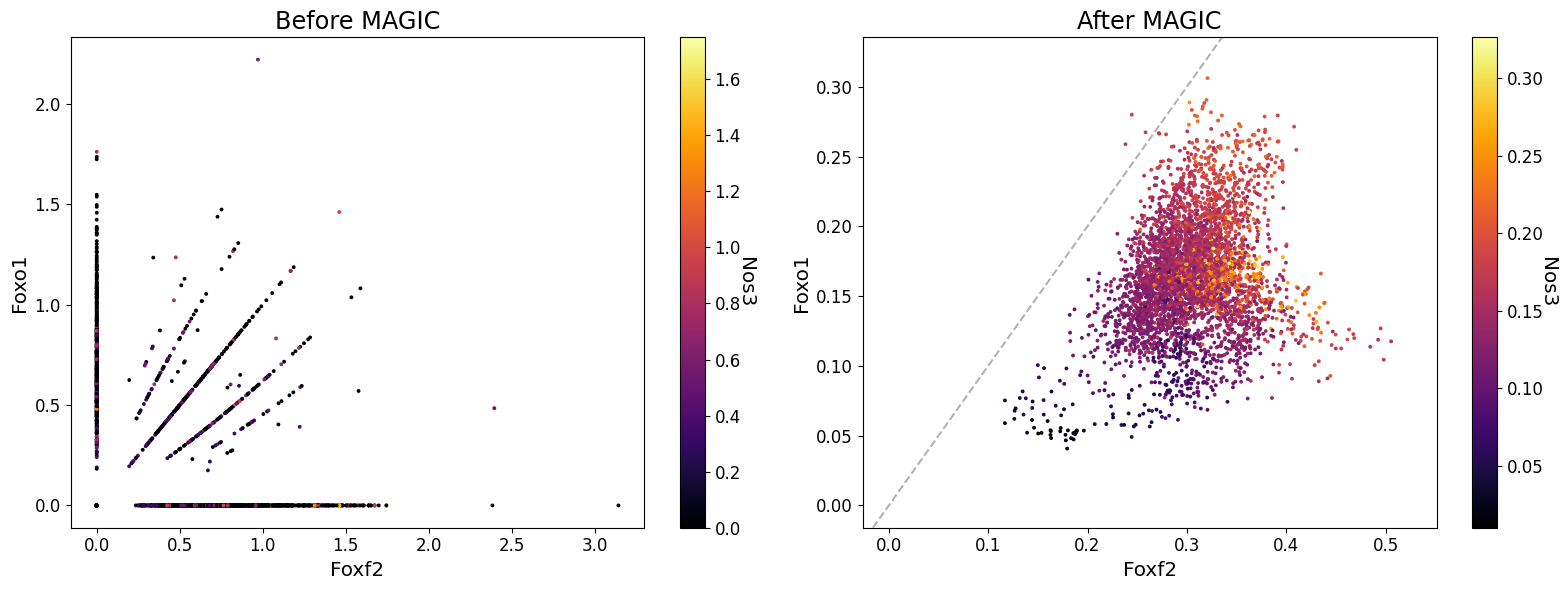

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## SMCs

In [91]:
gg = ["Foxf2","Foxo1","Nos3"]

In [92]:
adata_EC = adata[adata.obs.clusters == "SMCs"]

In [93]:
adata_EC

View of AnnData object with n_obs × n_vars = 1575 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'cell_type_colors', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [94]:
adata_EC.layers

LayersView with keys: counts, normalized

In [95]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [96]:
cutoff_var = None

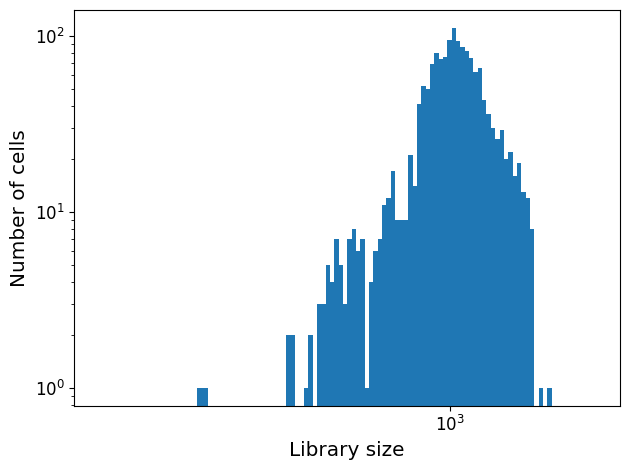

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [97]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [98]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [99]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [100]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [101]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 1575 cells and 27998 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.57 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.30 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 2.15 seconds.
  Calculating imputation...
Calculated MAGIC in 2.25 seconds.
CPU times: total: 4.23 s
Wall time: 2.25 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [102]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.7336534660537584

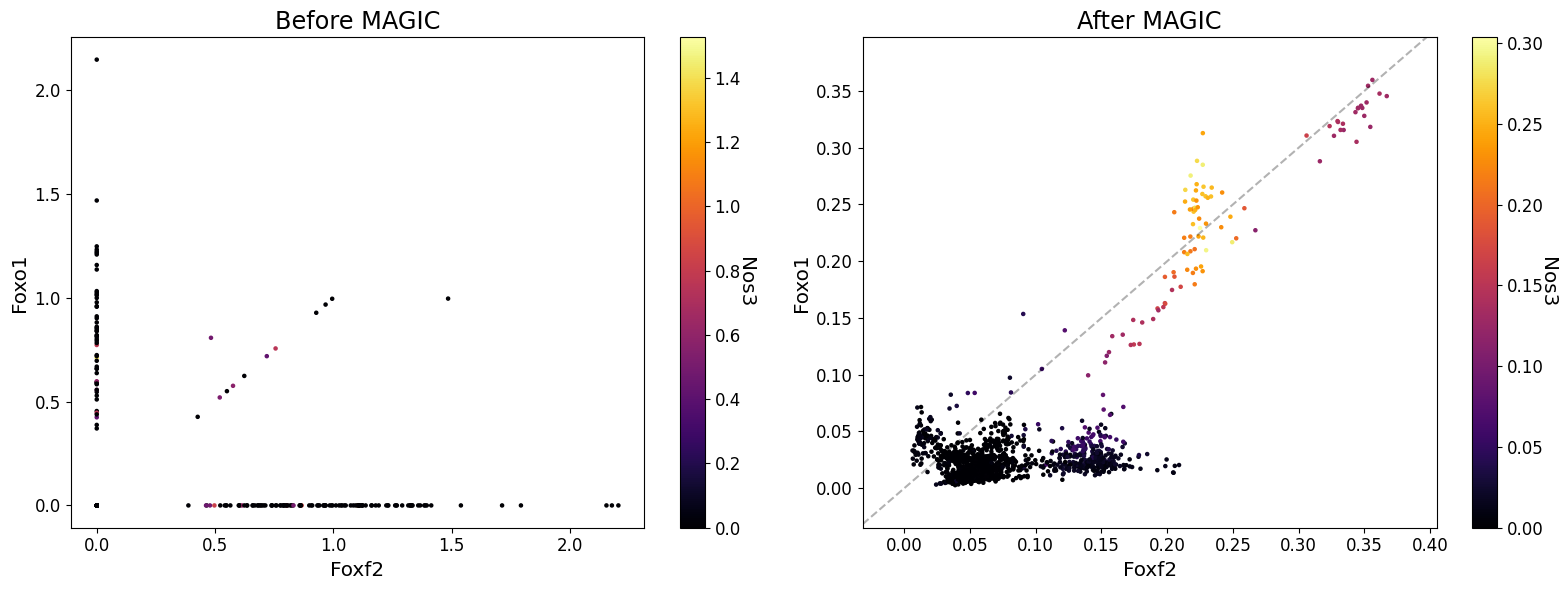

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## All cell types

In [52]:
adata

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'cell_type_colors', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [53]:
#matrix = pd.DataFrame(adata.X) # not compatible with sparse 
matrix = adata.X
#matrix.columns = ad_merged.var.index.tolist()

In [54]:
cutoff_var = 700

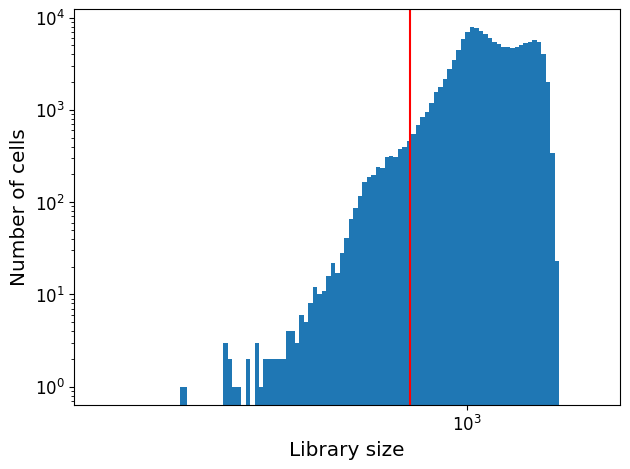

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [55]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [56]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [57]:
adata.layers

Layers with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [58]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [59]:
%%time
emt_magic = magic_op.fit_transform(adata, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 135459 cells and 27998 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 99.86 seconds.
    Calculating KNN search...
    Calculated KNN search in 1355.37 seconds.
    Calculating affinities...
    Calculated affinities in 1353.95 seconds.
  Calculated graph and diffusion operator in 2809.37 seconds.
  Calculating imputation...
  Calculated imputation in 0.06 seconds.
Calculated MAGIC in 2811.08 seconds.
CPU times: total: 46min 28s
Wall time: 46min 51s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [63]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.2945248174297121

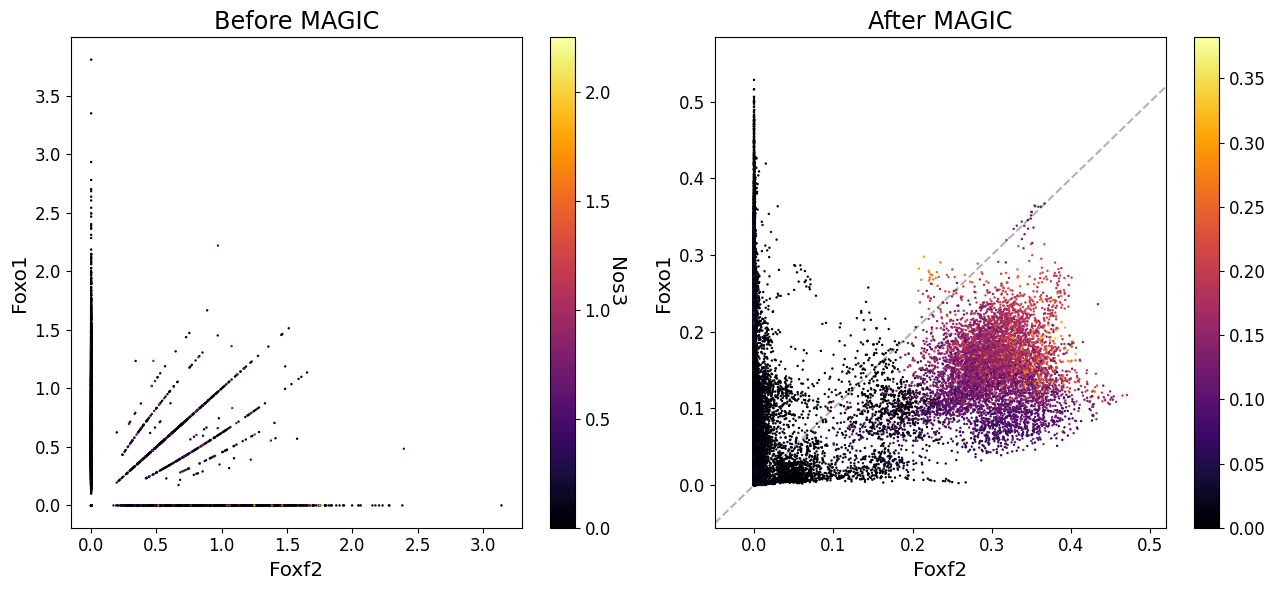

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13, 6))

scprep.plot.scatter(x=adata[:,'Foxf2'].X.todense(), y=adata[:,'Foxo1'].X.todense(), c=adata[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')

scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Save

In [105]:
adata

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'cell_type_colors', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [106]:
name='zeisel_normalised_logarithmised_annotated'

In [107]:
adata.write(main_dir+"\P06_Foxf2_per_celltype\\scRNAseq\\" + date.today().strftime("%Y%m%d")+'_'+name+'.h5ad')

# Session Info

In [104]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.15.1
charset_normalizer  2.0.4
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
deprecated          1.2.14
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
future              0.18.3
graphtools          1.5.3
h5py                3.9.0
idna                3.4
igraph              0.10.4
ipykernel           6.25.0
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.1
jinja2              3.0.3
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_server      1.23.4
jupyterlab_server   2